## <center> Homework 2 <center>

#### Authors: Silva Bashllari, Gioele Giachino

In [1]:
# importing the libraries that are required to set up the environment
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# here we are setting some values for the design of the graphs drawings that are going to be used in all the exercises
options = {
    'node_color': 'black',
    'node_size': 250,
    'width': 1,
    'with_labels': True,
    'font_color':'pink',
    'alpha': 0.9,
}

## <center> Exercise 1 </center>

#### The first part of this assignment consists in studying a single particle performing a continuous-time random walk in the network described by the graph in figure and with the following transition rate matrix.

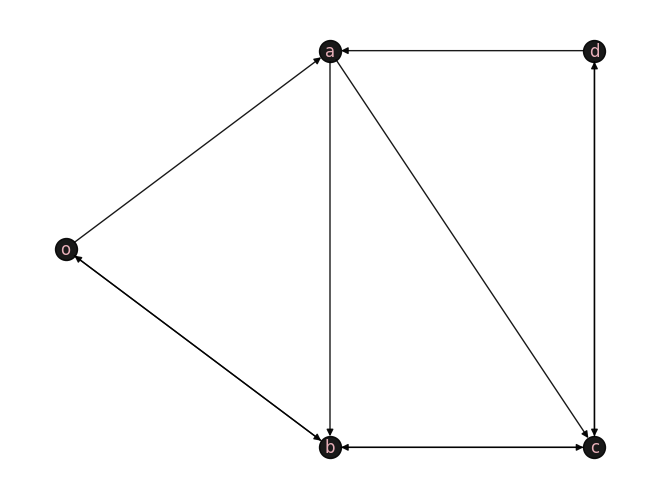

In [3]:
G_1 = nx.DiGraph()
edges_list_1 = [('o','a'),('o','b'),('a','b'),('a','c'),('b','o'),('b','c'),('d','a'),('d','c'), ('c', 'd'), ('c', 'b')]
G_1.add_edges_from(edges_list_1)
pos = {"o":[2,2], "a":[4,4], "b":[4,0], "c":[6,0], "d":[6,4] }
nx.draw(G_1,pos, **options)

In [4]:
# Transition rate matrix lambda
tr_matrix = np.array([[0, 2/5, 1/5, 0, 0],
                   [0, 0, 3/4, 1/4, 0],
                   [1/2, 0, 0, 1/3, 0],
                   [0, 0, 1/3, 0, 2/3],
                   [0, 1/2, 0, 1/3, 0]])

In [5]:
tr_matrix

array([[0.        , 0.4       , 0.2       , 0.        , 0.        ],
       [0.        , 0.        , 0.75      , 0.25      , 0.        ],
       [0.5       , 0.        , 0.        , 0.33333333, 0.        ],
       [0.        , 0.        , 0.33333333, 0.        , 0.66666667],
       [0.        , 0.5       , 0.        , 0.33333333, 0.        ]])

In [6]:
# checking some properties of the graph
# since it is fully connected we can say that in terms of the Markov Chains X(t) is ergodic
print(f'Graph properties: strongly connected: {nx.algorithms.components.is_strongly_connected(G_1)} and  aperiodic: {nx.is_aperiodic(G_1)}.')

Graph properties: strongly connected: True and  aperiodic: True.


### The main idea in simulating CTMC:
In order to model the Continous Time Markov Chains (CTMC) different approaches might be taken. Here the chosen approach is using a "global" Possion Clock with rate w-star, thus the particle has both choices: of jumping to another node or staying in the same node. The way this is done is by taking the already provided transition rate matrix lambda and computing the sum of each row and storing it in a vector w. Then the maximum value of this vector w is taken into account and it is named w-star which serves as the rate of the clock. A reminder that the main difference between the discrete and continous time Markov Chains is that in the latter not only the jumps between the states (nodes) are an element of randomness but also the time elapsed by two consecuitive jumps an exponential random variable with rate r.  Then, this clock runs and let's assume the particle is at some node i. When the global clock ticks the particle can either jump at node j with a probability:
$
Q_{ij} = \frac{\Lambda_{ij}}{\omega_{*}}, \;
$
or stay in node i with a probability:
$Q_{ii} = 1 - \sum_{i \neq j} Q{ij}$.
Thus you discretize the continous time in terms of the tics of the Poisson Clock.

#### The Poisson clock Function

In [7]:
# Global clock with rate w_star
def Qmatrix_Jump_Chain(tr_matrix):
    w = np.sum(tr_matrix, axis=1) # the sum of the rows vector w
    w_star = np.max(w) # the scalar maximum of all the w vector entries
    Q = tr_matrix/w_star # Definition of the Jump Chain of the Continuous Time Markov Chain(CTMC)
    Q = Q + np.diag(np.ones(len(w))-np.sum(Q,axis=1)) #Diagonal addition to make sure that the rows sum to 1
    return Q

#get w-star
def get_w_star(tr_matrix):
   w = np.sum(tr_matrix, axis=1)
   w_star = np.max(w)
   return w_star, w


In [8]:
Q = Qmatrix_Jump_Chain(tr_matrix)
Q

array([[0.4       , 0.4       , 0.2       , 0.        , 0.        ],
       [0.        , 0.        , 0.75      , 0.25      , 0.        ],
       [0.5       , 0.        , 0.16666667, 0.33333333, 0.        ],
       [0.        , 0.        , 0.33333333, 0.        , 0.66666667],
       [0.        , 0.5       , 0.        , 0.33333333, 0.16666667]])

In [9]:
w_star, w = get_w_star(tr_matrix)
print(f'The max value is {w_star} and the vector is {w}')

The max value is 1.0 and the vector is [0.6        1.         0.83333333 1.         0.83333333]


#### Simulation implementation

In [10]:
# Q = Jump chain, matrix defined using the function above
# initial_state = the initial state from which the simulation will start.
# w_star = rate of the exponential distribution, inter-arrival time
# destination - the destination state
def start_simulation(Q, w_star, initial_state, destination):
    destination = destination
    pos = [] # pos will keep trace of the visited states
    pos.append(initial_state) #Start at the initial state declared
    transition_times = [0] # transition_times will store the time instants at which jumps/transitions happen

    # using the formula to compute the next time, the random time to wait for the next transition is drawn according to its distribution
    t_next = -np.log(np.random.rand())/w_star
    # How to compute the jump? Use intervals defined according the cumulative probability distribution...
    # 1. Compute the cumulative sums of the rows of Q => if a = np.array([[1,2,3]) then
    #    np.cumsum(a, axis=1) gives array([[ 1,  3,  6])
    # 2. Sample a random number in the interval (0,1) then associate a basket proportional to the probability.
    #    For example if p(1,1) = 0, p(1,2) = 0.2, p(1,3) = 0.4,  p(1,4) = 0.4 then
    #    P = (0,0.2,0.4,0.4) => P_cum (0,0.2,0.6,1) => Random number drawn = 0.7 => Go to state 4
    Q_cum = np.cumsum(Q, axis=1)


    i = 1
    while True:
        # the next state to visit will be extracted according to the probabilities
        # stored in the row of Q corresponding to the current state.
        # In general, to extract a value pos[i] in (0,...,num_states-1) according to the discrete
        # distribution Q[pos[i-1],:], you can extract a random number in [0,1] and compare it with
        # the cumulative sums Q_cum[pos[i-1]]. You then pick the first (smallest) state for which
        # the cumulative sum is grater than the random number.
        pos.append(int(np.argwhere(Q_cum[pos[i-1]] > np.random.rand())[0]))

        # store the time instant of the current transition
        transition_times.append(transition_times[i-1] + t_next)

        if pos[i] == destination:
            return transition_times, pos, i

        # compute the waiting time to the next transition
        t_next = -np.log(np.random.rand())/w_star
        i += 1

    return transition_times,pos,i


### Computing the pi-bar vector towards which the probabilities are supposed to converge to if time goes to infinity

In [11]:
values,vectors = np.linalg.eig(Q.T)
print(values.real)
index = np.argmax(values.real)
print(index)
pi_bar = vectors[:,index].real
pi_bar = pi_bar/np.sum(pi_bar)
print("pi_bar=", pi_bar)

[ 1.          0.5        -0.10585951 -0.10585951 -0.55494766]
0
pi_bar= [0.23058252 0.16504854 0.27669903 0.18203883 0.14563107]


#### a) What is, according to the simulations, the average time it takes a particle that starts in node a to leave the node and then return to it?


In [12]:
# we run the simulation here
nr_sim =  100000# set the number of steps in the simulation
times = np.zeros(nr_sim)
four_paths = []
for j in range(nr_sim):
    # States are mapped in this way: o = 0, a = 1, b = 2, c = 3, d = 4
    simulation_time, nodes_visited, steps = start_simulation(Q, w_star = w_star, initial_state=1, destination=1)
    #print(steps)
    #print(simulation_time)
    #print(nodes_visited)
    times[j] = simulation_time[steps]
    if j < 4:
        four_paths.append(nodes_visited)
# Compute the simulated mean return time
print(f'The first four paths the particle takes are {four_paths}')
#print(times)
empirical_avg_time = np.mean(times)
print("The simulated expected return time from node 'a' is : {}".format(empirical_avg_time))

<ipython-input-10-99f7e76b1304>:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pos.append(int(np.argwhere(Q_cum[pos[i-1]] > np.random.rand())[0]))


The first four paths the particle takes are [[1, 3, 4, 1], [1, 2, 0, 1], [1, 2, 0, 1], [1, 2, 0, 0, 0, 1]]
The simulated expected return time from node 'a' is : 6.055030694464428


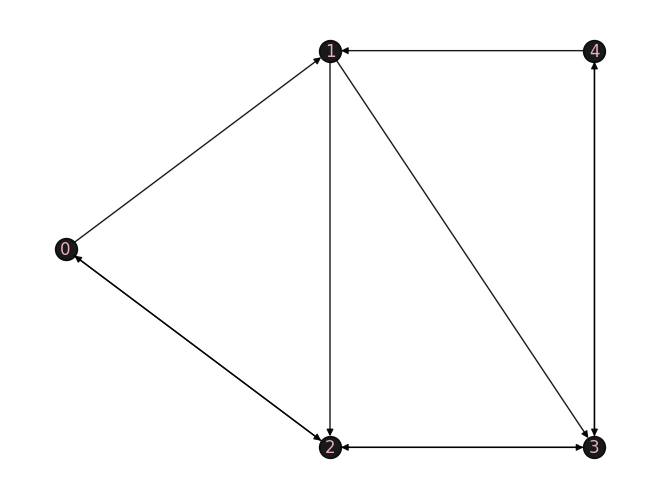

In [13]:
G_1_p = nx.DiGraph()
edges_list_1_numeric = [(0, 1), (0, 2), (1, 2), (1, 3), (2, 0), (2, 3), (4, 1), (4, 3), (3, 4), (3, 2)]# Adjusted edges for numerical labels
G_1_p.add_edges_from(edges_list_1_numeric)
pos = {0: [2, 2], 1: [4, 4], 2: [4, 0], 3: [6, 0], 4: [6, 4]}
nx.draw(G_1_p, pos, **options)

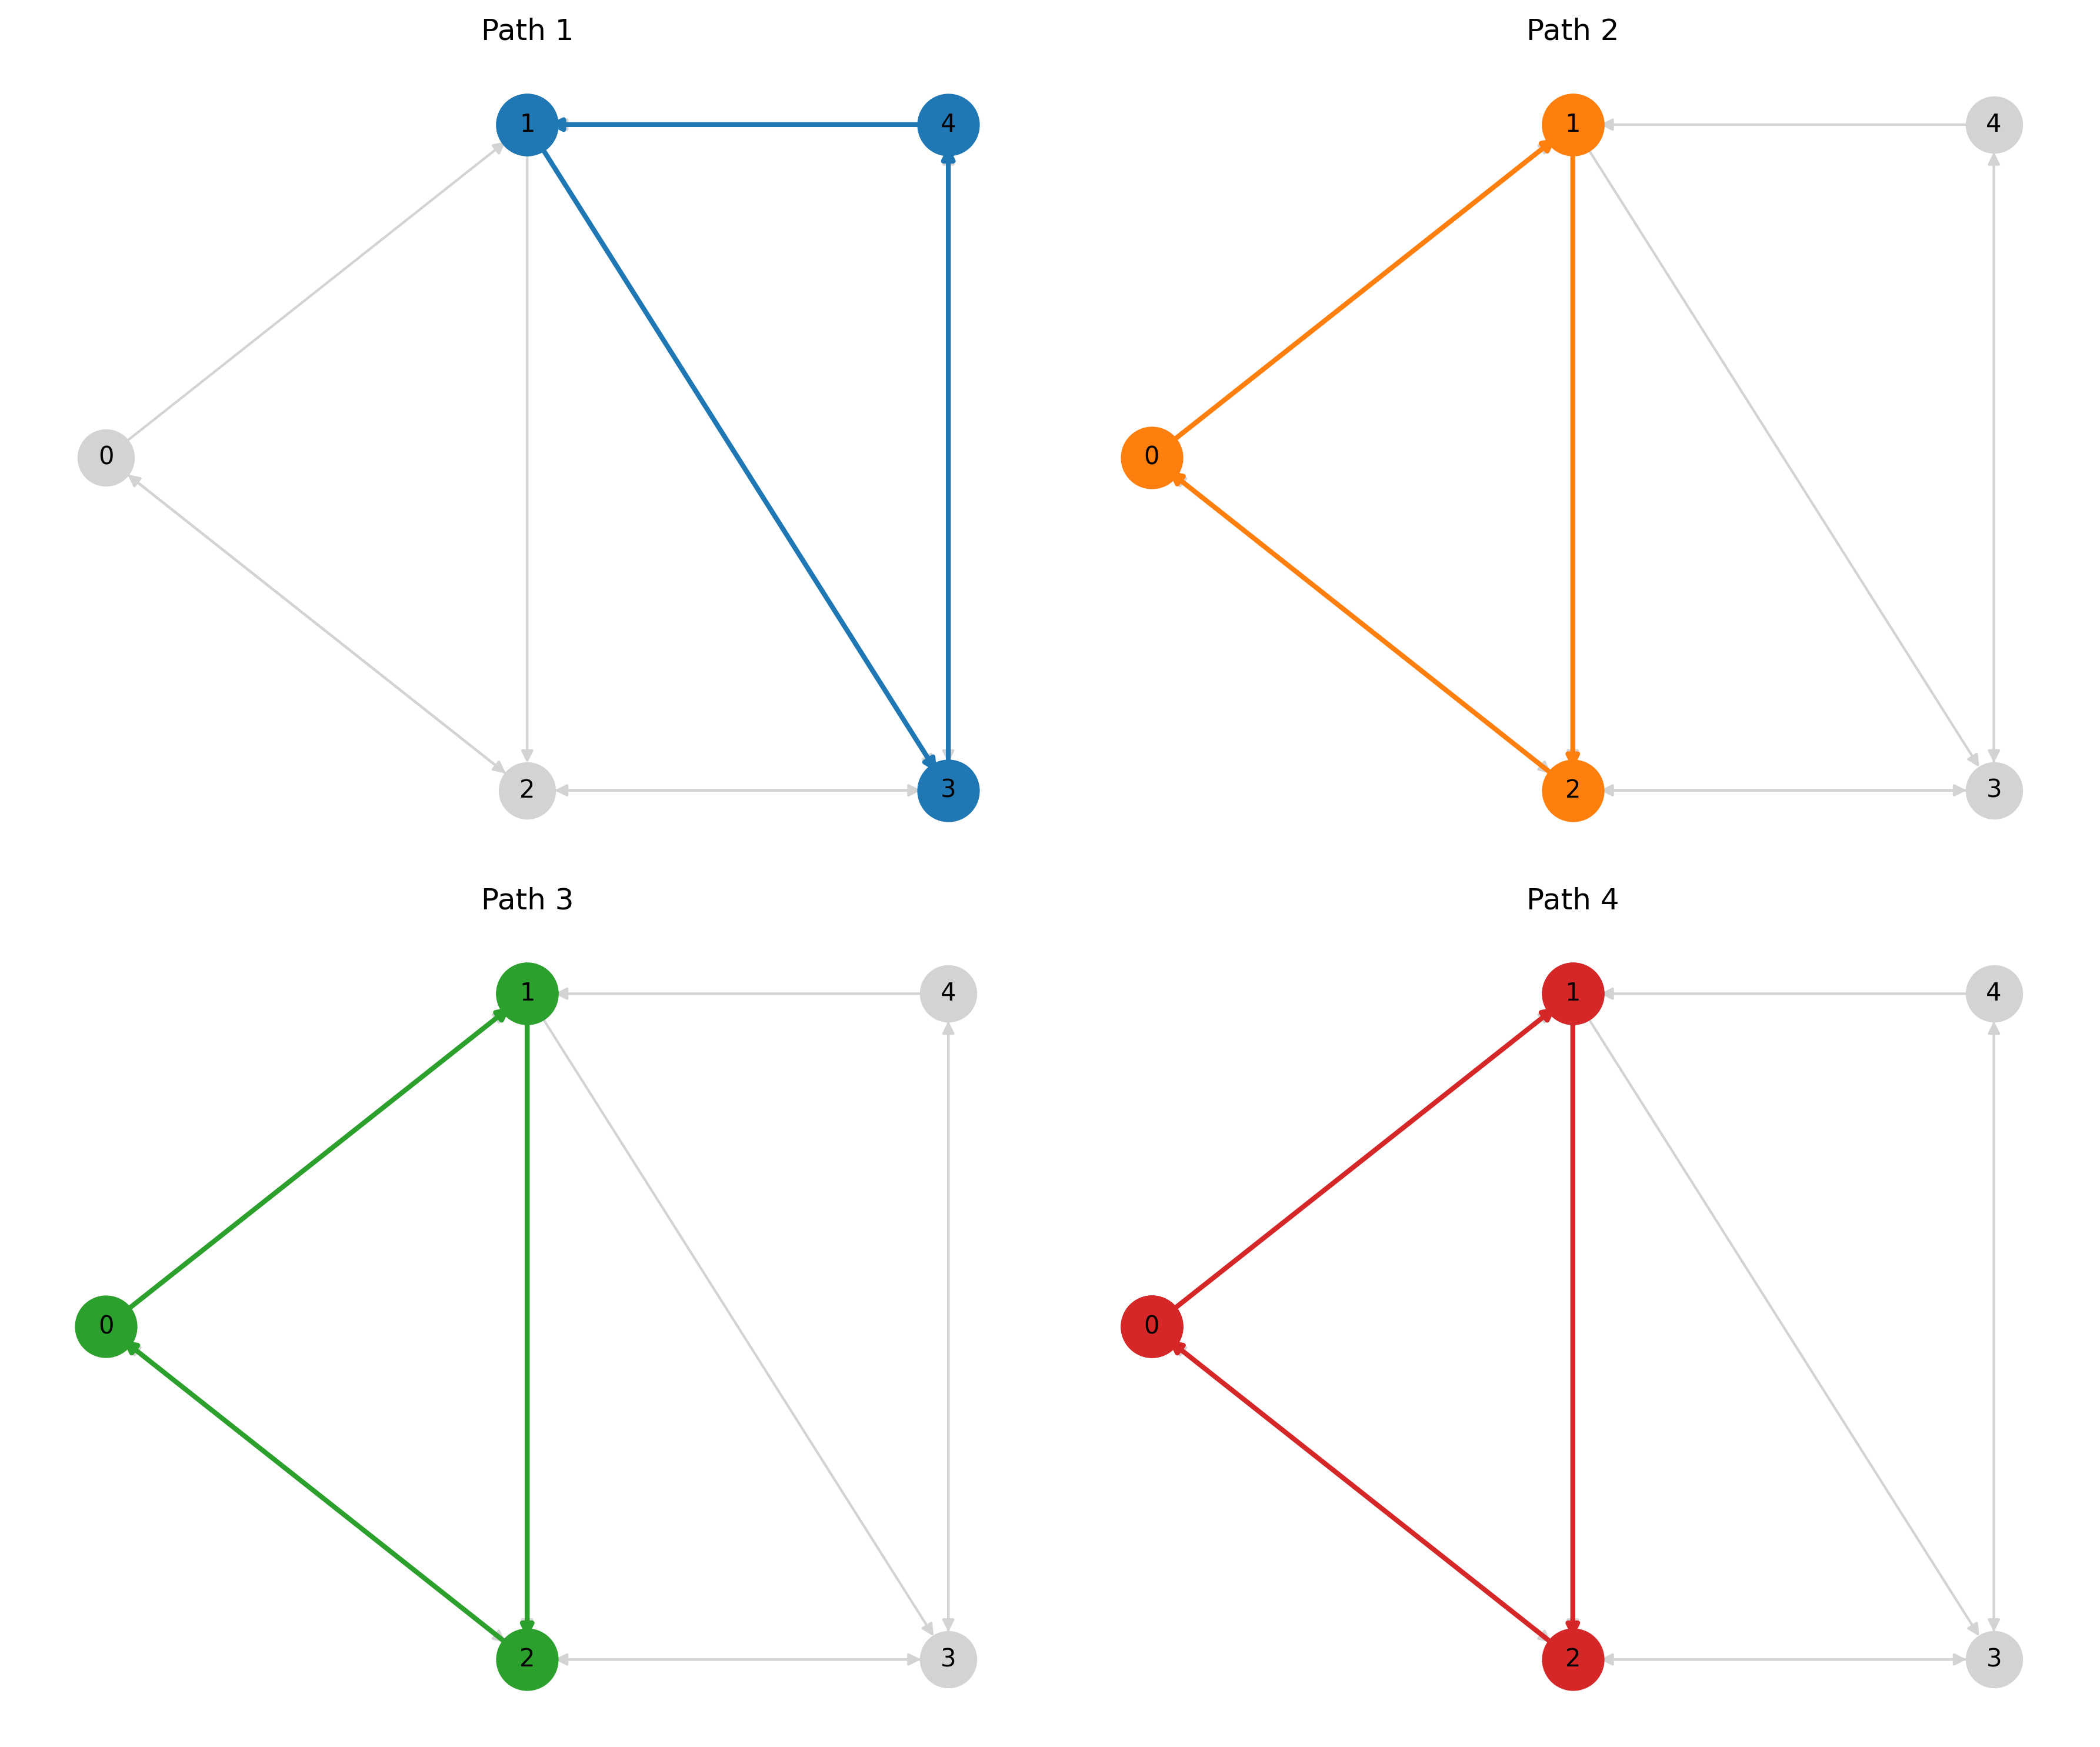

In [14]:
# Create a subplot grid for 2 rows and 2 columns
fig, axes = plt.subplots(2, 2, figsize=(12, 10), dpi=300)

# Flatten the axes array for easier indexing
axes = axes.flatten()

for i, path in enumerate(four_paths):
    ax = axes[i]  # Select the appropriate subplot
    ax.set_title(f"Path {i + 1}")

    # Draw the base graph
    nx.draw(
        G_1_p,
        pos,
        with_labels=True,
        node_color="lightgray",
        edge_color="lightgray",
        node_size=500,
        font_size=10,
        ax=ax,  # Pass the current axis
    )

    # Highlight the edges in the current path
    path_edges = [
        (path[j], path[j + 1]) for j in range(len(path) - 1) if G_1_p.has_edge(path[j], path[j + 1])
    ]
    nx.draw_networkx_edges(G_1_p, pos, edgelist=path_edges, edge_color=f"C{i}", width=2, ax=ax)

    # Highlight the nodes in the current path
    nx.draw_networkx_nodes(G_1_p, pos, nodelist=path, node_color=f"C{i}", node_size=600, ax=ax)

# Remove unused subplots if there are fewer than 4 paths
for j in range(len(four_paths), 4):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig("fourpaths.png")
plt.show()


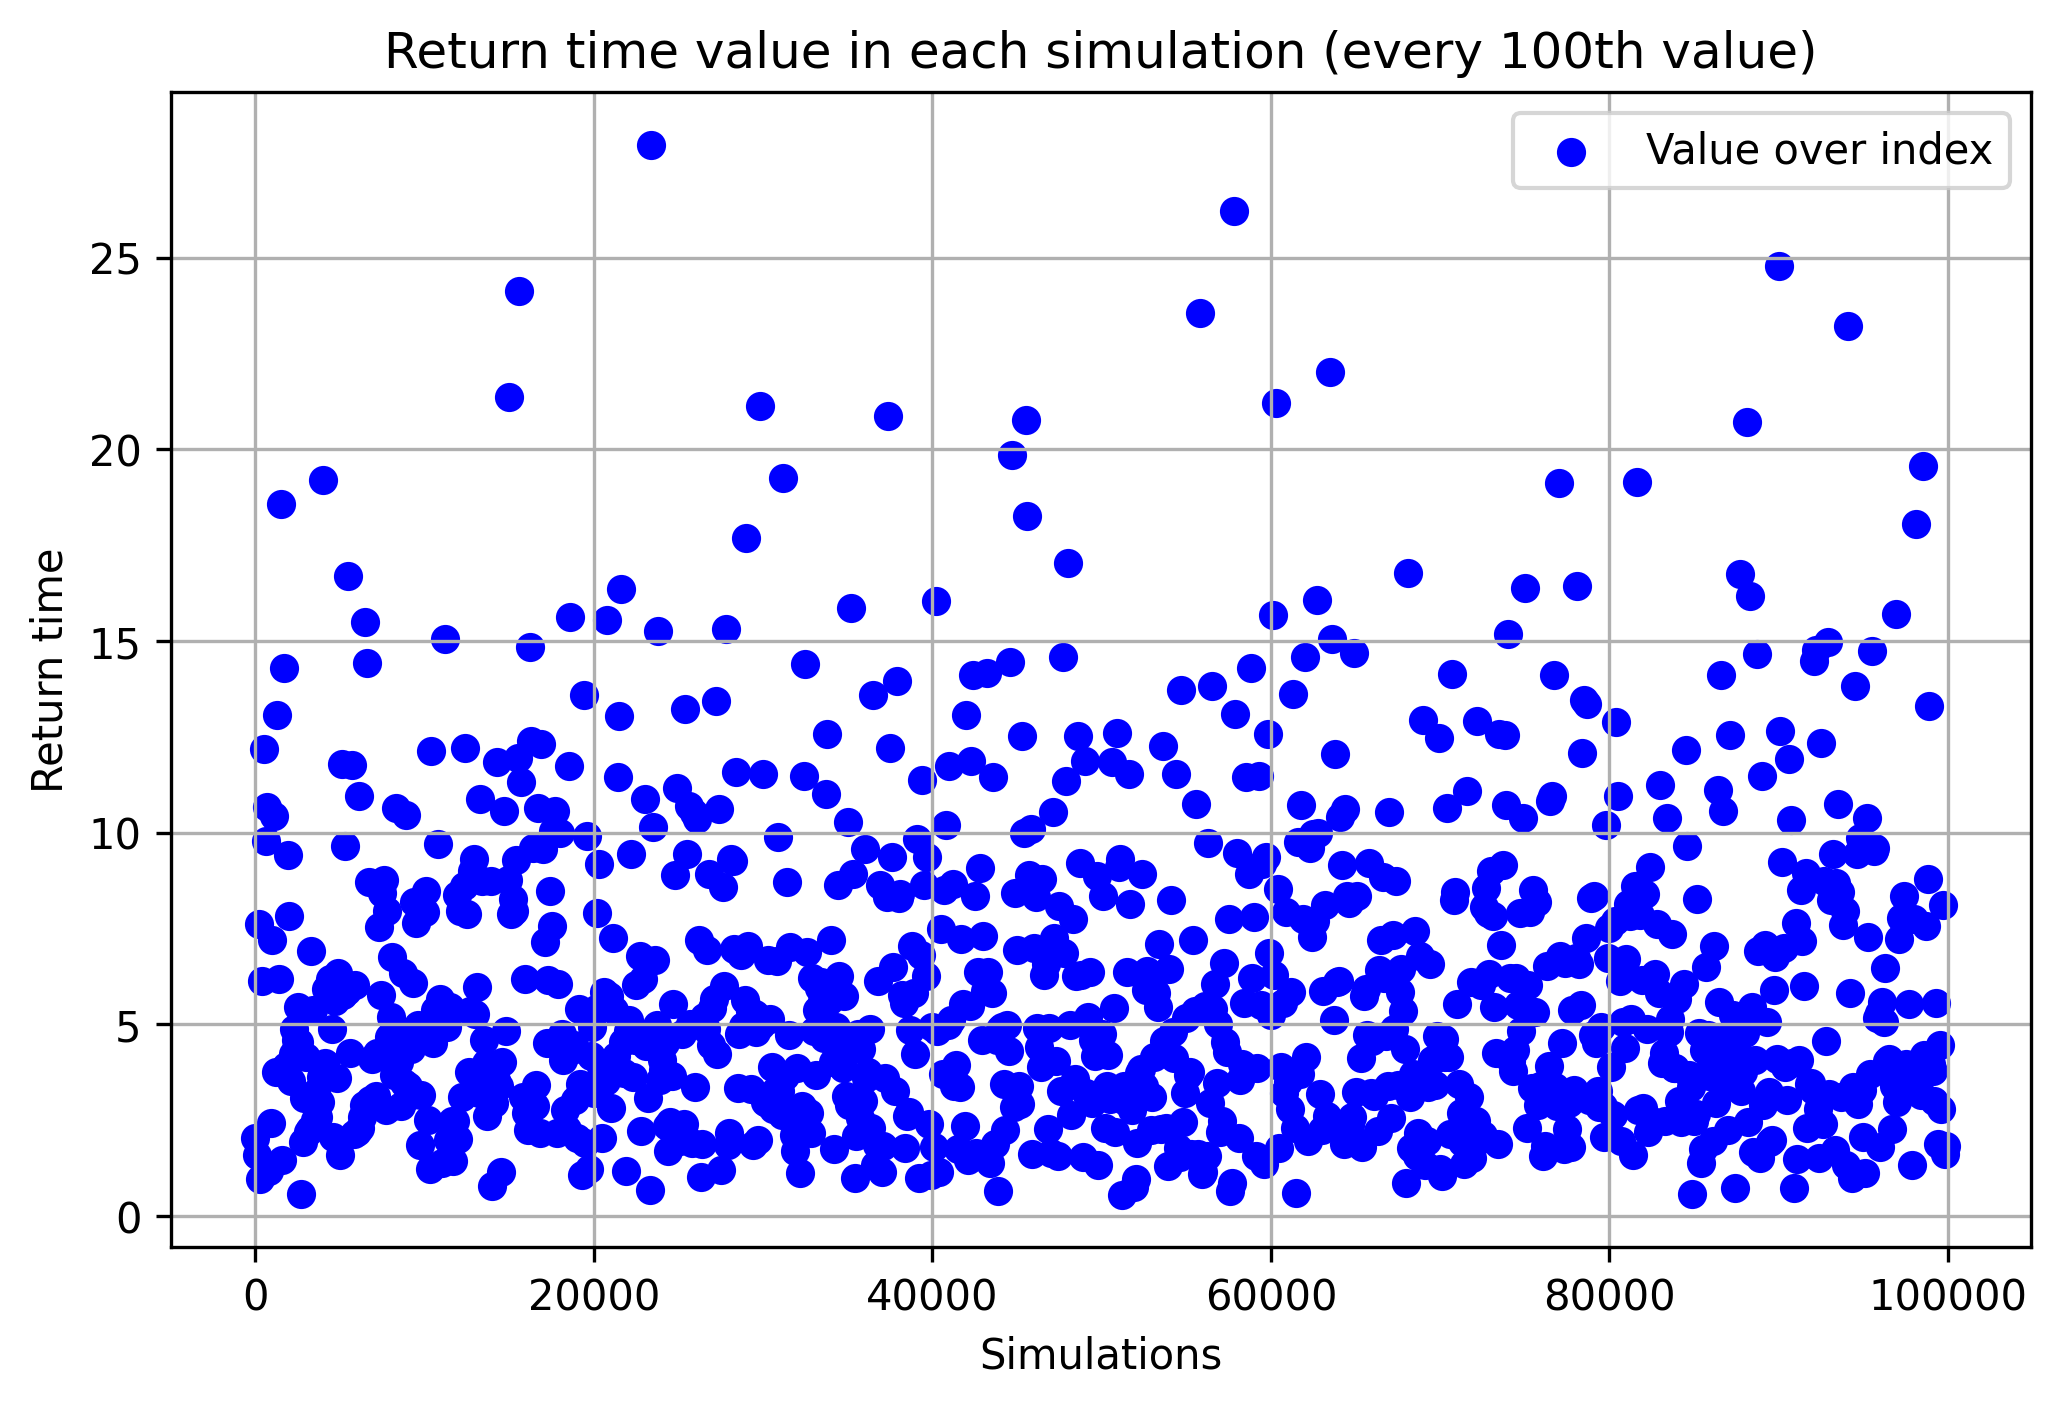

In [15]:
# Slice the data to take every 100th value in times because otherwise the graph is too "polluted"
indices = range(0, len(times), 100)
sampled_times = [times[i] for i in indices]

# Scatter plot of the sampled data
plt.figure(figsize=(8, 5), dpi = 300)
plt.scatter(indices, sampled_times, color='b', label='Value over index')
plt.xlabel('Simulations')
plt.ylabel('Return time')
plt.title('Return time value in each simulation (every 100th value)')
plt.legend()
plt.grid(True)
plt.savefig('returntime_a.png')
plt.show()

##### As it can be observed in the graph there is a lot of oscillations but that is normal given that 100.000 simulations are not infinity.

#### b) How does the result in a) compare to the theoretical return-time E_a[T+_a]? (Include a description of how this is computed.)

The theoretical expected return time can be computed using the following formula:
Return time: $ \mathbb{E}[T^+_i] = \frac{1}{\omega_i \pi_i} $

In [16]:
theoretical_return_time_a = 1 / (pi_bar[1]*w[1]) # compute using the above formula and taking the element at index=1 which corresponds to node a
print("The theoretical expected return time from node 'a' is : {}".format(theoretical_return_time_a))

The theoretical expected return time from node 'a' is : 6.058823529411766


In [17]:
#computing the difference:
diff_theoretical_returntime_empirical_return = theoretical_return_time_a -empirical_avg_time
print('The difference is: {}'.format(diff_theoretical_returntime_empirical_return))
diff_theoretical_returntime_empirical_return_quad = (theoretical_return_time_a -empirical_avg_time)**2
print('The difference is in quadratic terms: {}'.format(diff_theoretical_returntime_empirical_return_quad))

The difference is: 0.003792834947338619
The difference is in quadratic terms: 1.4385596937753146e-05


#### c) What is, according to the simulations, the average time it takes to move from node o to node d?

In [18]:
n_simulations =  100000
times_c = np.zeros(n_simulations)

for j in range(n_simulations):
    # States are mapped in this way: o = 0, a = 1, b = 2, c = 3, d = 4
    simulation_time, nodes_visited, steps = start_simulation(Q, w_star, initial_state=0, destination=4)
    times_c[j] = simulation_time[steps]
# Compute the simulated mean return time
print("The simulated expected return time from node 'o' to 'd' is : {}".format(np.mean(times_c) ) )

<ipython-input-10-99f7e76b1304>:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pos.append(int(np.argwhere(Q_cum[pos[i-1]] > np.random.rand())[0]))


The simulated expected return time from node 'o' to 'd' is : 10.736387454827112


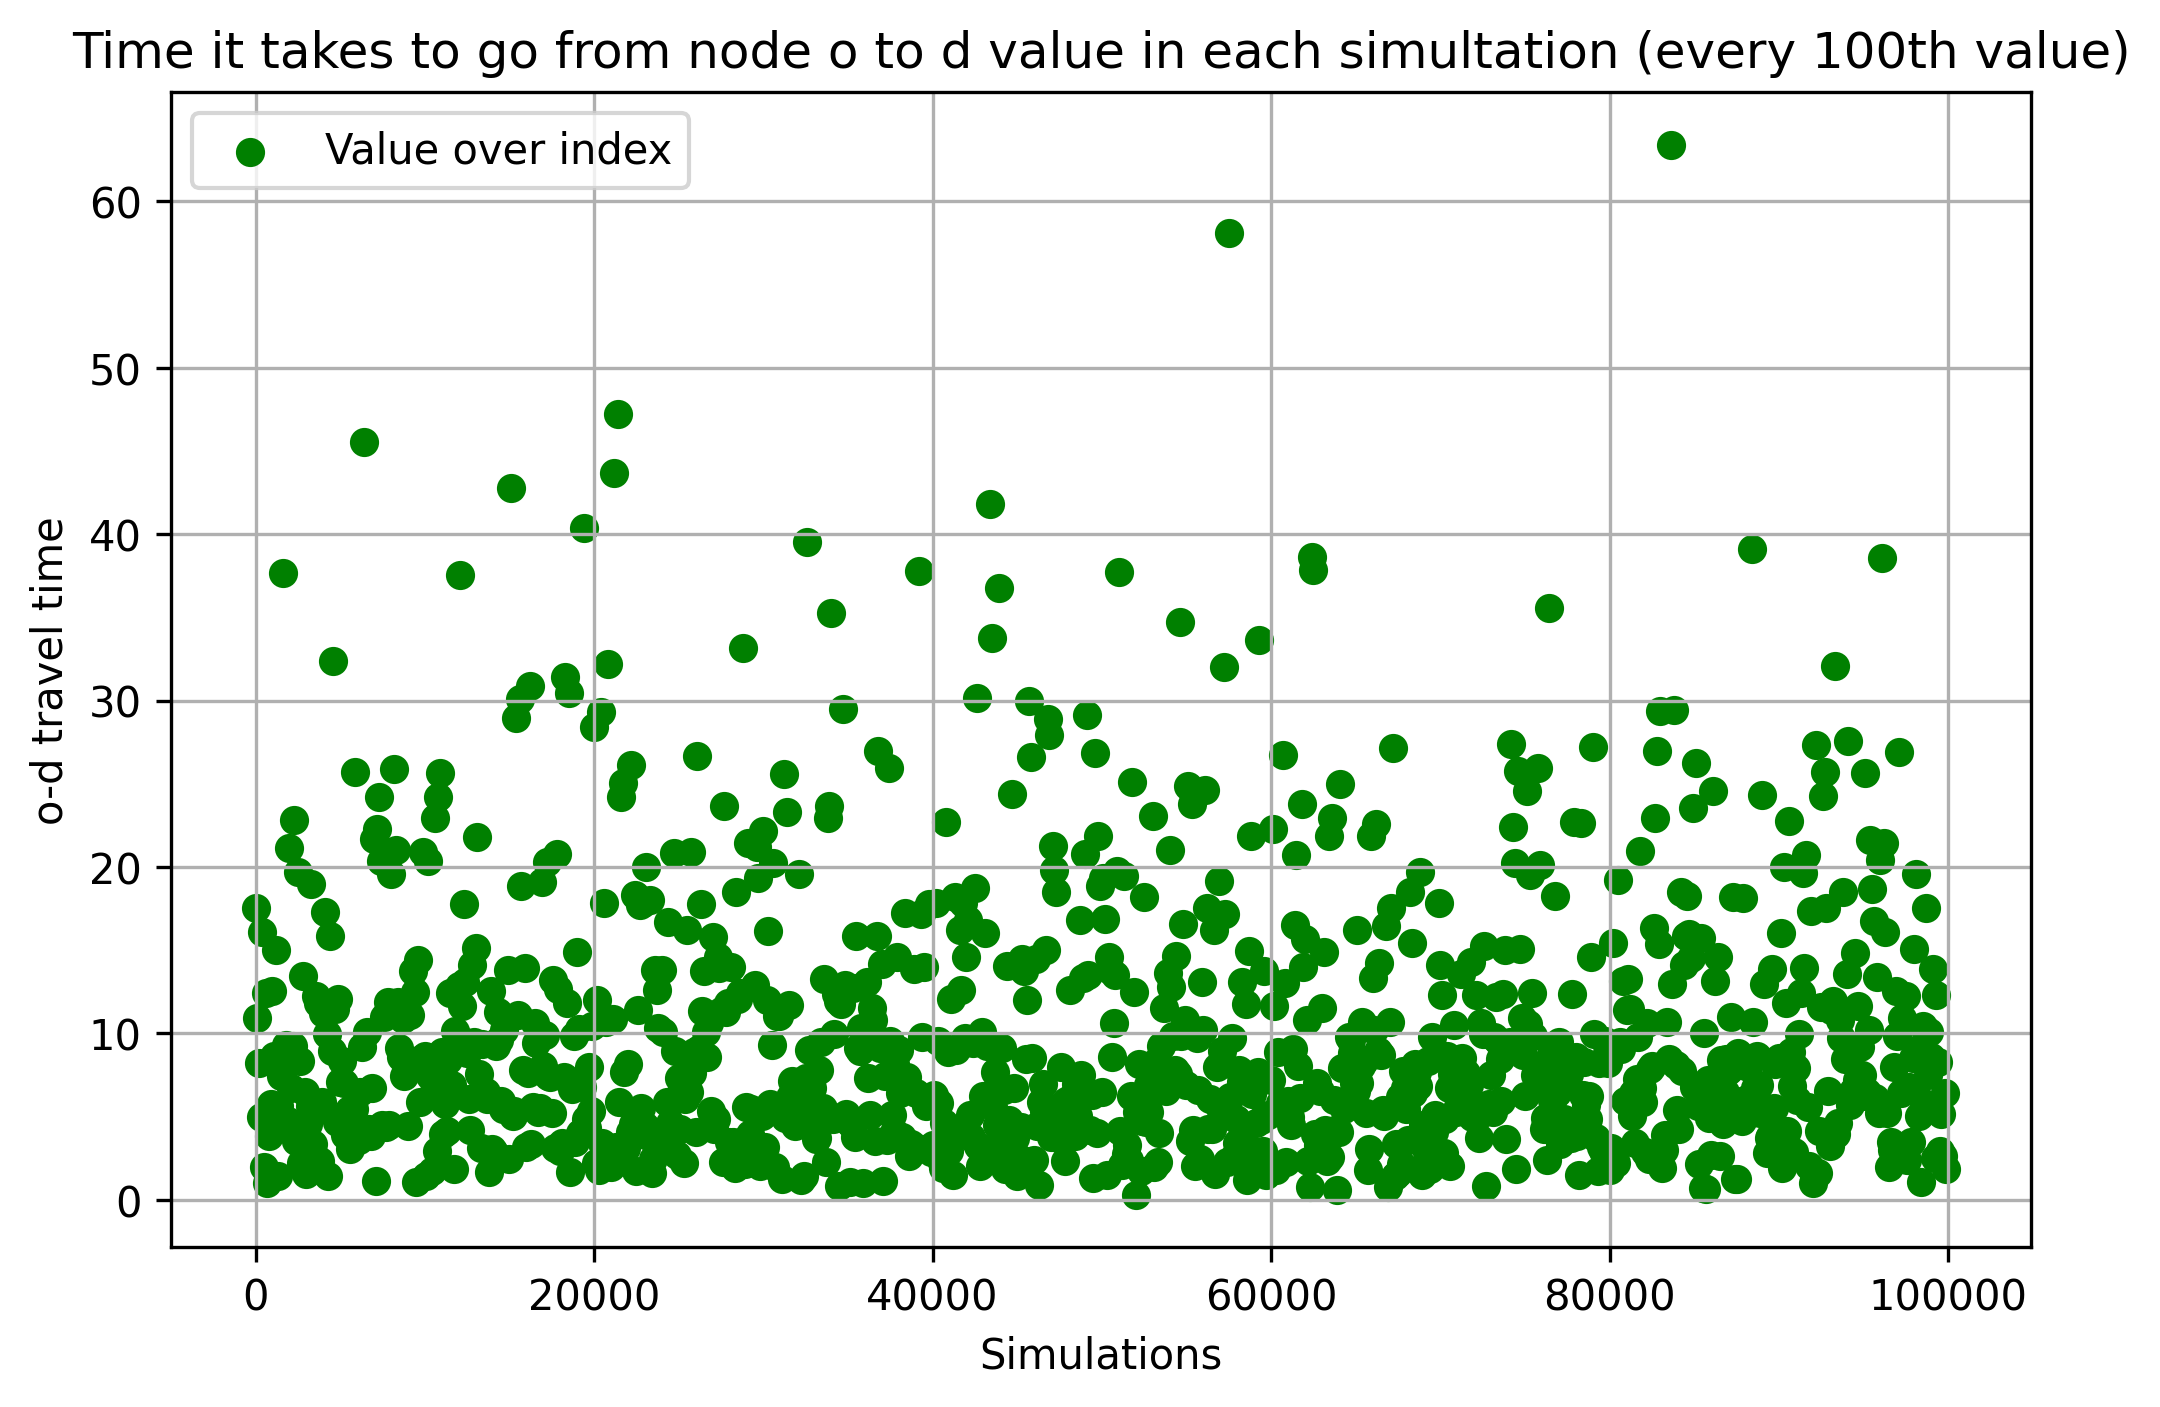

In [19]:
# Slice the data to take every 100th value in times because otherwise the graph is too "polluted"
indices_c = range(0, len(times_c), 100)
sampled_times_c = [times_c[i] for i in indices_c]

# Scatter plot of the sampled data
plt.figure(figsize=(8, 5), dpi=300)
plt.scatter(indices_c, sampled_times_c, color='g', label='Value over index')
plt.xlabel('Simulations')
plt.ylabel('o-d travel time')
plt.title('Time it takes to go from node o to d value in each simultation (every 100th value)')
plt.legend()
plt.grid(True)
plt.savefig("traveltime_o_d.png")
plt.show()

#### d) How does the result in c) compare to the theoretical hitting-time E_o[T_d]? (Describe also how this is computed.)

The formula used to calculate the hitting time:
$$
{\mathbb{E}}_o[T_S] = \frac{1}{\omega_o} + \sum_{ j} P_{oj}{\mathbb{E}}_j[T_S]
$$
where $S \subseteq V$ and $S=\{d\}$

To obtain $\frac{1}{\omega_o} + \sum_{ j} P_{oj}{\mathbb{E}}_j[T_S]$ we consider $R =V \backslash S $ and $Q = P_{|R x R}, \tau \in \mathbb{R}^{R} $

$\tau = \frac{\mathbb{1}}{\omega} + Q\tau  \Longleftrightarrow (I-Q)\tau = \frac{\mathbb{1}}{\omega} \Longleftrightarrow \tau = (I-Q)^{-1}\frac{\mathbb{1}}{\omega}$


$(I-Q)$ is invertible because $V \backslash S$  has a link pointing to S


In [20]:
print(f'The transition matrix lambda is: {tr_matrix}')
print(f'The row sum vector w is: {w}')

The transition matrix lambda is: [[0.         0.4        0.2        0.         0.        ]
 [0.         0.         0.75       0.25       0.        ]
 [0.5        0.         0.         0.33333333 0.        ]
 [0.         0.         0.33333333 0.         0.66666667]
 [0.         0.5        0.         0.33333333 0.        ]]
The row sum vector w is: [0.6        1.         0.83333333 1.         0.83333333]


In [21]:
#first remove row and column associated to (V) from Q, which corresponds to the last row and the last column.
a =np.linalg.inv(np.diag(w[0:4]))@(np.array(tr_matrix)[:4,:4])
print(f'The q matrix in RxR is: {a}')
I = np.identity(4)
onesw =1 / w[0:4]
tau = np.linalg.inv(I-a) @ (1 / w[0:4])
print("Tau vector is:")
print(tau)

The q matrix in RxR is: [[0.         0.66666667 0.33333333 0.        ]
 [0.         0.         0.75       0.25      ]
 [0.6        0.         0.         0.4       ]
 [0.         0.         0.33333333 0.        ]]
Tau vector is:
[10.76666667  9.          9.3         4.1       ]


In [22]:
expected_tr_time_o_d = tau[0]
expected_tr_time_o_d

10.766666666666666

In [23]:
sim_travel_time_o_d = np.mean(times_c)
sim_travel_time_o_d

10.736387454827112

In [24]:
error1 = sim_travel_time_o_d - expected_tr_time_o_d  # compute error
error2 = (sim_travel_time_o_d - expected_tr_time_o_d )**2 # compute error in quadratic terms
print(f'The errors are: {error1} and {error2}')

The errors are: -0.030279211839554065 and 0.0009168306696245911


#### e) Interpret the matrix Λ as the weight matrix of a graph G = (V, E,Λ), and simulate the FrenchDeGroot dynamics on G with an arbitrary initial condition x(0). Does the dynamics converge to a consensus state for every initial condition x(0)? Motivate your answer.

We have verified at the start of this assignement that the necessary properties of this graph hold in order to be able to simulate the French-De Groot.

In [25]:
tr_matrix

array([[0.        , 0.4       , 0.2       , 0.        , 0.        ],
       [0.        , 0.        , 0.75      , 0.25      , 0.        ],
       [0.5       , 0.        , 0.        , 0.33333333, 0.        ],
       [0.        , 0.        , 0.33333333, 0.        , 0.66666667],
       [0.        , 0.5       , 0.        , 0.33333333, 0.        ]])

In [26]:
x0_test1 = [10,20,15,25,40] # arbitrarily chosen values of x0 as asked but without many outliers
x0_test1

[10, 20, 15, 25, 40]

In [27]:
x0_test2 = [10,20,15,25,400] # providing a much higher value than the rest to one of the nodes that has a high centrality
x0_test2

[10, 20, 15, 25, 400]

In [28]:
# Define matrix P each entry of P is defined as follows => P_i,j = Lambda_i,j / w_i
degrees = np.sum(tr_matrix,axis=1)
D = np.diag(degrees)
P = np.linalg.inv(D) @ tr_matrix
P

array([[0.        , 0.66666667, 0.33333333, 0.        , 0.        ],
       [0.        , 0.        , 0.75      , 0.25      , 0.        ],
       [0.6       , 0.        , 0.        , 0.4       , 0.        ],
       [0.        , 0.        , 0.33333333, 0.        , 0.66666667],
       [0.        , 0.6       , 0.        , 0.4       , 0.        ]])

In [29]:
# simulate the French De Groot
# we know that the initial opinion values are as provided in x0
# then the opinions at every t+1 evolve as follows:  x(t+1)=Px(t)
opinions1 = []
opinions2 = []
def sim_french_de_groot(nr_sim, P, x, opinions):
    for i in range(nr_sim):
        opinions.append(x)
        x = P @ x
        print(f'Opinions vector: is {x}')
    print(f'After {nr_sim} iterations the opinion vector has reached the following value: {x}')

In [30]:
sim_french_de_groot(30,P,x0_test1, opinions1)

Opinions vector: is [18.33333333 17.5        16.         31.66666667 22.        ]
Opinions vector: is [17.         19.91666667 23.66666667 20.         23.16666667]
Opinions vector: is [21.16666667 22.75       18.2        23.33333333 19.95      ]
Opinions vector: is [21.23333333 19.48333333 22.03333333 19.36666667 22.98333333]
Opinions vector: is [20.33333333 21.36666667 20.48666667 22.66666667 19.43666667]
Opinions vector: is [21.07333333 21.03166667 21.26666667 19.78666667 21.88666667]
Opinions vector: is [21.11       20.89666667 20.55866667 21.68       20.53366667]
Opinions vector: is [20.784 20.839 21.338 20.542 21.21 ]
Opinions vector: is [21.00533333 21.139      20.6872     21.25266667 20.7202    ]
Opinions vector: is [20.9884     20.82856667 21.10426667 20.7092     21.18446667]
Opinions vector: is [20.92046667 21.0055     20.87672    21.15773333 20.78082   ]
Opinions vector: is [20.96257333 20.94697333 21.01537333 20.81278667 21.06639333]
Opinions vector: is [20.96977333 20.96472

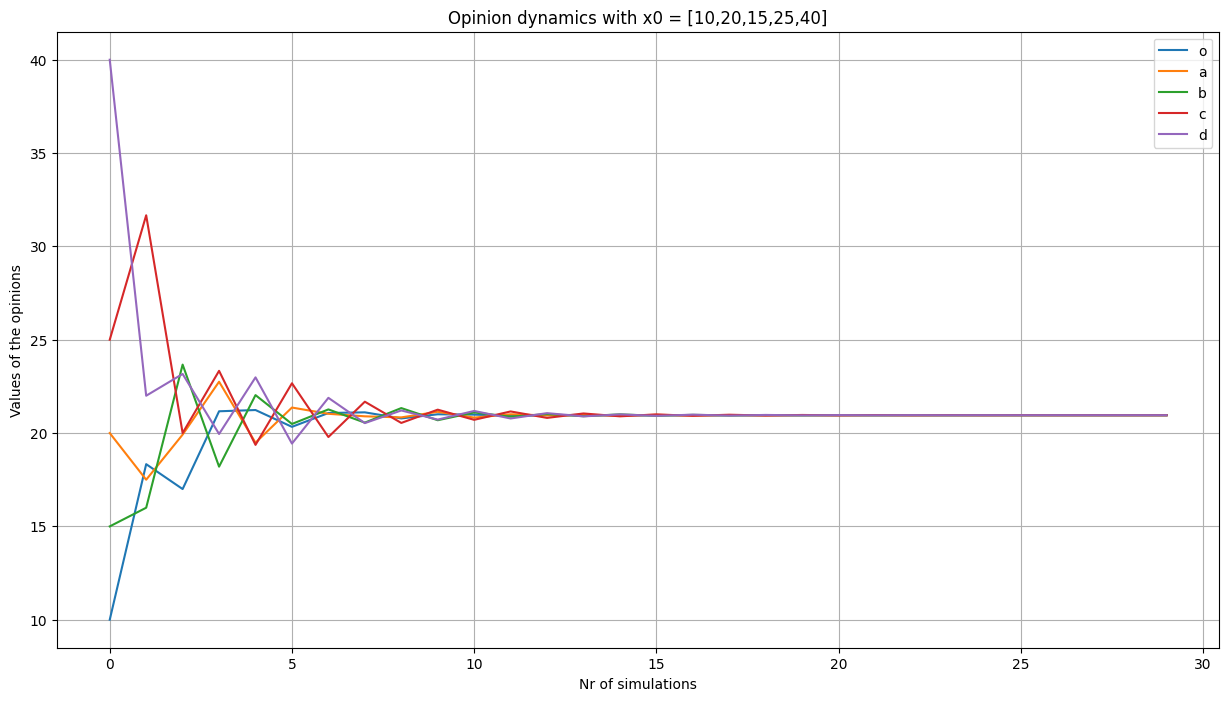

In [31]:
nodes_names = ["o","a","b","c","d"]

# Plot the opinions evolution in time
opinions1 = np.array(opinions1)
plt.figure(figsize=[15,8])

for x in range(opinions1.shape[1]):
    plt.plot(opinions1[:,x])

plt.grid()
plt.legend(nodes_names)
plt.title("Opinion dynamics with x0 = [10,20,15,25,40]")
plt.xlabel("Nr of simulations")
plt.ylabel("Values of the opinions")
plt.savefig('op1.png', dpi=600)
plt.show()

In [32]:
sim_french_de_groot(30,P,x0_test2, opinions2)

Opinions vector: is [ 18.33333333  17.5         16.         271.66666667  22.        ]
Opinions vector: is [ 17.          79.91666667 119.66666667  20.         119.16666667]
Opinions vector: is [ 93.16666667  94.75        18.2        119.33333333  55.95      ]
Opinions vector: is [ 69.23333333  43.48333333 103.63333333  43.36666667 104.58333333]
Opinions vector: is [ 63.53333333  88.56666667  58.88666667 104.26666667  43.43666667]
Opinions vector: is [78.67333333 70.23166667 79.82666667 48.58666667 94.84666667]
Opinions vector: is [73.43       72.01666667 66.63866667 89.84       61.57366667]
Opinions vector: is [70.224 72.439 79.994 63.262 79.146]
Opinions vector: is [74.95733333 75.811      67.4392     79.42866667 68.7682    ]
Opinions vector: is [73.0204     70.43656667 76.74586667 68.3252     77.25806667]
Opinions vector: is [72.53966667 74.6407     71.14232    77.08733333 69.59202   ]
Opinions vector: is [73.47457333 72.62857333 74.35873333 70.10878667 75.61935333]
Opinions vector:

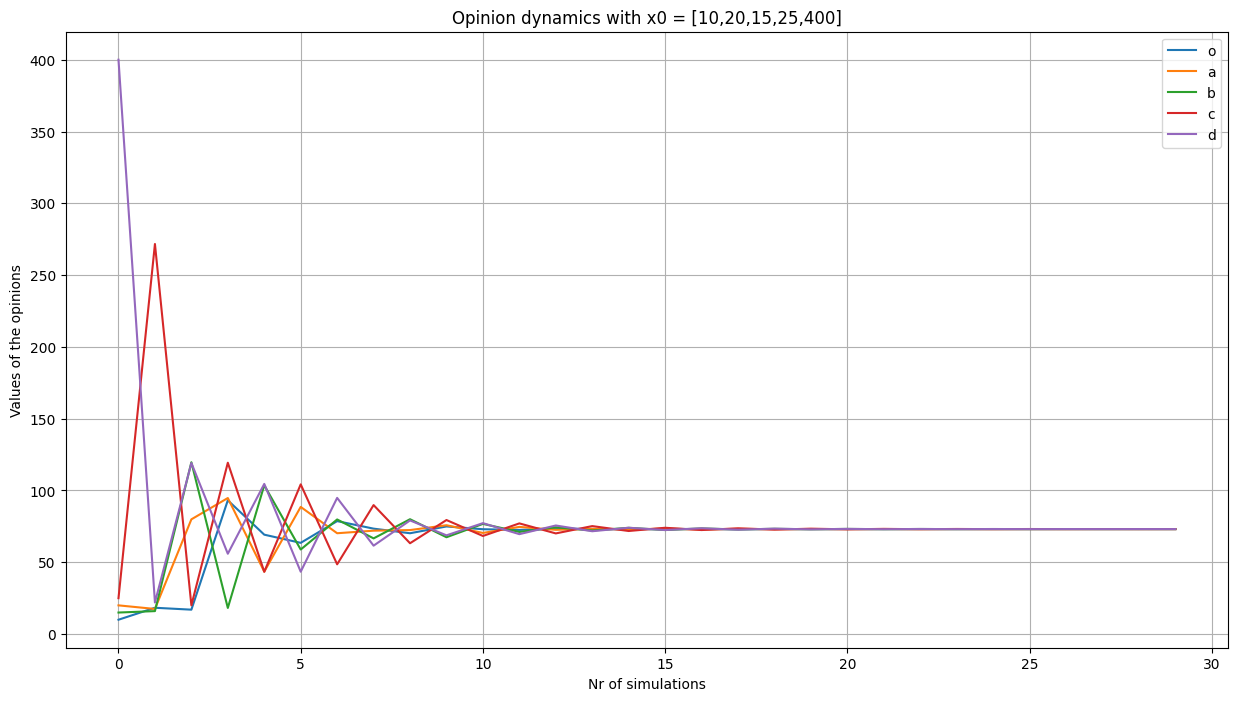

In [33]:
# Plot the opinions evolution in time
opinions2 = np.array(opinions2)
plt.figure(figsize=[15,8])

for x in range(opinions2.shape[1]):
    plt.plot(opinions2[:,x])

plt.grid()
plt.legend(nodes_names)
plt.title("Opinion dynamics with x0 = [10,20,15,25,400]")
plt.xlabel("Nr of simulations")
plt.ylabel("Values of the opinions")
plt.savefig('op2.png', dpi=600)
plt.show()

In [34]:
def comp_eigenvector_one(matrix):
    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eig(matrix.T)
    # Find the index of the eigenvalue closest to 1
    index = np.argmin(np.abs(eigenvalues - 1))
    # Get the corresponding eigenvector
    pi = eigenvectors[:, index].real
    # Normalize the eigenvector to ensure it sums to 1
    pi = pi / np.sum(pi)
    print(f"Eigenvector corresponding to eigenvalue ~1: {pi}")
    return pi

In [35]:
eig = comp_eigenvector_one(P)

Eigenvector corresponding to eigenvalue ~1: [0.16521739 0.19710145 0.27536232 0.2173913  0.14492754]


In [36]:
# we know that the consensus vector as t goes to inifinity is supposed to converge to this:
cons_1 = comp_eigenvector_one(P) @ x0_test1
print(f'The consensus value is supposed to be the following: {cons_1}') #computing the consensus value for the provided x0_test
print(f'The vector in the last round of simulations is: {opinions1[-1]}')

Eigenvector corresponding to eigenvalue ~1: [0.16521739 0.19710145 0.27536232 0.2173913  0.14492754]
The consensus value is supposed to be the following: 20.956521739130434
The vector in the last round of simulations is: [20.95652066 20.95663011 20.95628418 20.95695264 20.95618058]


In [37]:
cons_2 = comp_eigenvector_one(P) @ x0_test2
print(f'The consensus value is supposed to be the following: {cons_2}') #computing the consensus value for the provided x0_test
print(f'The vector in the last round of simulations is: {opinions2[-1]}') #computing the consensus value for the provided x0_test

Eigenvector corresponding to eigenvalue ~1: [0.16521739 0.19710145 0.27536232 0.2173913  0.14492754]
The consensus value is supposed to be the following: 73.13043478260866
The vector in the last round of simulations is: [73.13043226 73.13289143 73.12534167 73.13943914 73.123267  ]


#### f) Assume that the initial state of the dynamics for each node i ∈ V is given by xi(0) = ξi, where {ξi}i∈V are independent random variables with variance:

*   σ2_a = σ2_b = σ2_c = 2;
*   σ2_o = σ2_d = 1.

#### Compute the variance of the consensus value, and compare your results with the numerical simulations.


We know that in a G=(V,E,W) is str. connected, aperiodic, The initial opinioni sa noisy measurement of a true variable µ:
 xi(0)=µ+Ni, Ni independent r.v. E[Ni]=0 Var(Ni)= sigma-square

In [40]:
err = np.zeros(20)

for i in range(20):
    #print(x)
    x = np.random.rand(5) #sample with uniform distribution 5 nrs
    for _ in range(100):
        x = P @ x
    #print(alfa_err)
    err[i] = (1/2 - np.mean(x))**2 #compute the error from 1/2 which is the expected mean of the uniform distribtion with the mean we get in the simulation

 # variance of uniform distribution over [0, 1]
print("Variance of the node states:", 1/12)
print("Variance of the consensus state:", np.mean(err))

Variance of the node states: 0.08333333333333333
Variance of the consensus state: 0.012668849900124545


#### g) Remove the edges (d, a),(d, c),(a, c),(b, c). Describe and motivate the asymptotic behaviour of the dynamics. If the dynamics converges to an asymptotic state, how is such a state related to the initial condition x(0)?

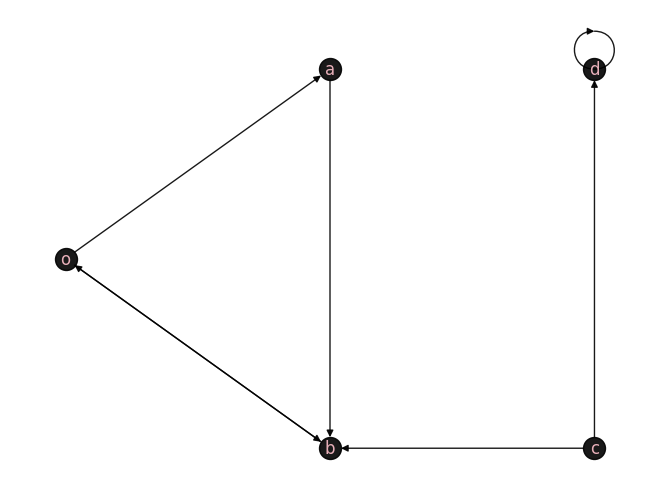

In [41]:
G1_partg = nx.DiGraph()
edges_list_1_g = [('o','a'),('o','b'),('a','b'),('b','o'),('c', 'd'), ('c', 'b'), ('d', 'd')]
G1_partg.add_edges_from(edges_list_1_g)
pos = {"o":[2,2], "a":[4,4], "b":[4,0], "c":[6,0], "d":[6,4] }
nx.draw(G1_partg,pos, **options)
plt.savefig("graphg")

Your connected components are: 
[{'o', 'b', 'a'}, {'d'}, {'c'}]


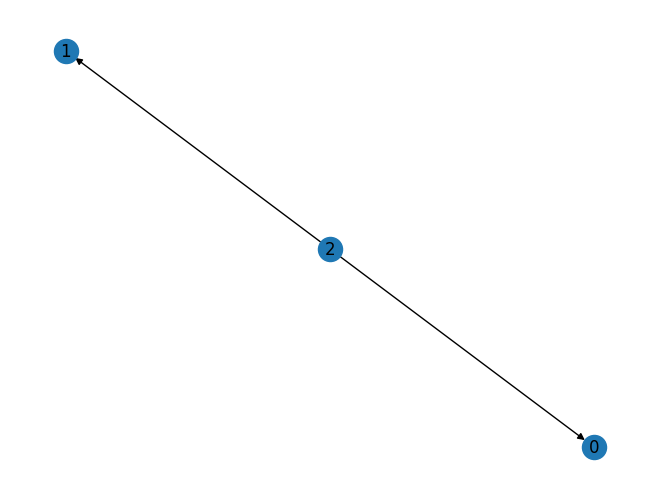

In [42]:
con_comp_g_list = list(nx.strongly_connected_components(G1_partg))
print("Your connected components are: ")
print(con_comp_g_list)
con_comp_g = nx.algorithms.components.condensation(G1_partg)
nx.draw(con_comp_g, with_labels=True)
plt.savefig('con_g.png')

In [43]:
print(f'Graph properties: strongly connected: {nx.algorithms.components.is_strongly_connected(G1_partg)} and  aperiodic: {nx.is_aperiodic(G1_partg)}.')

Graph properties: strongly connected: False and  aperiodic: True.


In [44]:
print('The original transition matrix was: ')
tr_matrix

The original transition matrix was: 


array([[0.        , 0.4       , 0.2       , 0.        , 0.        ],
       [0.        , 0.        , 0.75      , 0.25      , 0.        ],
       [0.5       , 0.        , 0.        , 0.33333333, 0.        ],
       [0.        , 0.        , 0.33333333, 0.        , 0.66666667],
       [0.        , 0.5       , 0.        , 0.33333333, 0.        ]])

In [45]:
## adapting the transition matrix to the changes in the graph:
tr_matrix_g = np.array([[0, 2/5, 1/5, 0, 0],
                   [0, 0, 3/4, 0, 0],
                   [1/2, 0, 0, 0, 0],
                   [0, 0, 1/3, 0, 2/3],
                   [0, 0, 0, 0, 1]]) # the one here is for the added self-loop
print('The new transition matrix is: ')
tr_matrix_g

The new transition matrix is: 


array([[0.        , 0.4       , 0.2       , 0.        , 0.        ],
       [0.        , 0.        , 0.75      , 0.        , 0.        ],
       [0.5       , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.33333333, 0.        , 0.66666667],
       [0.        , 0.        , 0.        , 0.        , 1.        ]])

In [46]:
degrees_g = np.sum(tr_matrix_g,axis=1)
D_g = np.diag(degrees_g)
P_g = np.linalg.inv(D_g) @ tr_matrix_g
print(P_g)

[[0.         0.66666667 0.33333333 0.         0.        ]
 [0.         0.         1.         0.         0.        ]
 [1.         0.         0.         0.         0.        ]
 [0.         0.         0.33333333 0.         0.66666667]
 [0.         0.         0.         0.         1.        ]]


In [47]:
opinions_g = []
sim_french_de_groot(30,P_g,x0_test1, opinions_g)

Opinions vector: is [18.33333333 15.         10.         31.66666667 40.        ]
Opinions vector: is [13.33333333 10.         18.33333333 30.         40.        ]
Opinions vector: is [12.77777778 18.33333333 13.33333333 32.77777778 40.        ]
Opinions vector: is [16.66666667 13.33333333 12.77777778 31.11111111 40.        ]
Opinions vector: is [13.14814815 12.77777778 16.66666667 30.92592593 40.        ]
Opinions vector: is [14.07407407 16.66666667 13.14814815 32.22222222 40.        ]
Opinions vector: is [15.49382716 13.14814815 14.07407407 31.04938272 40.        ]
Opinions vector: is [13.45679012 14.07407407 15.49382716 31.35802469 40.        ]
Opinions vector: is [14.5473251  15.49382716 13.45679012 31.83127572 40.        ]
Opinions vector: is [14.81481481 13.45679012 14.5473251  31.15226337 40.        ]
Opinions vector: is [13.82030178 14.5473251  14.81481481 31.51577503 40.        ]
Opinions vector: is [14.63648834 14.81481481 13.82030178 31.60493827 40.        ]
Opinions vector:

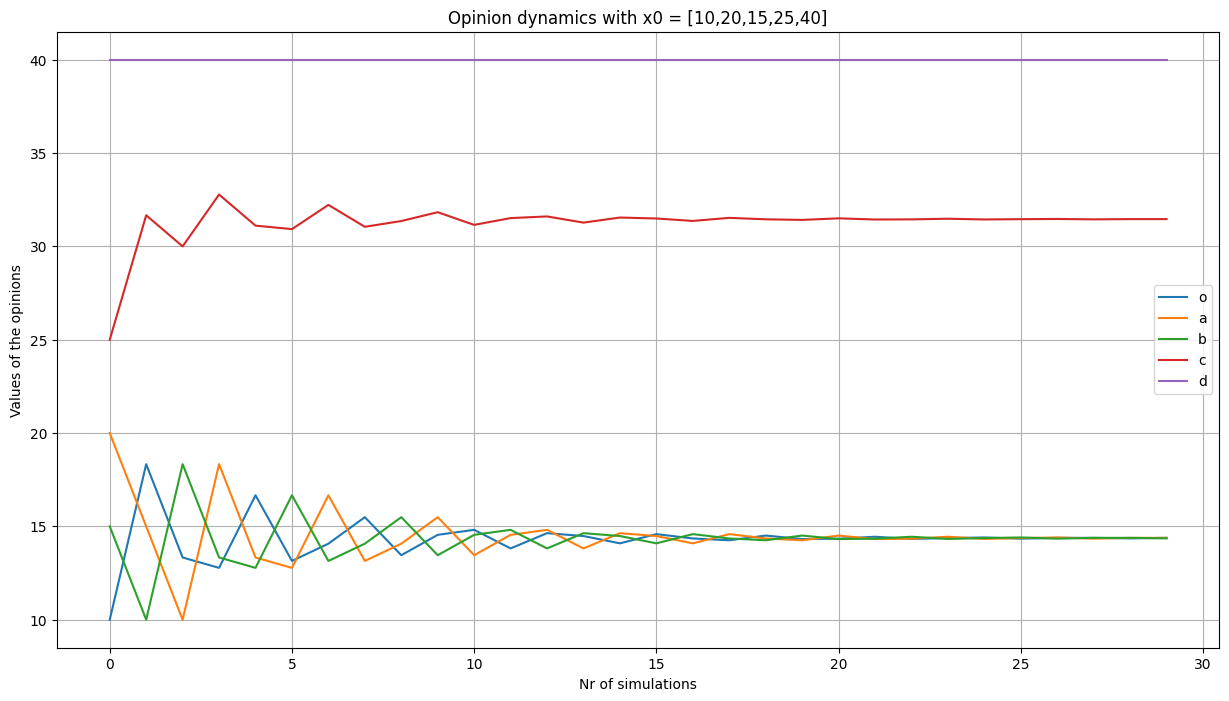

In [48]:
# Plot the opinions evolution in time
opinions_g = np.array(opinions_g)
plt.figure(figsize=[15,8])

for x in range(opinions_g.shape[1]):
    plt.plot(opinions_g[:,x])

plt.grid()
plt.legend(nodes_names)
plt.title("Opinion dynamics with x0 = [10,20,15,25,40]")
plt.xlabel("Nr of simulations")
plt.ylabel("Values of the opinions")
plt.savefig('opg.png', dpi=600)
plt.show()

#### h) Consider the graph (V, E,Λ), and remove the edges (b, o) and (d, a). Analyse the FrenchDeGroot dynamics on the new graph. In particular, describe how the asymptotic behaviour of the dynamics varies in terms of the initial condition x(0), and motivate your answer.


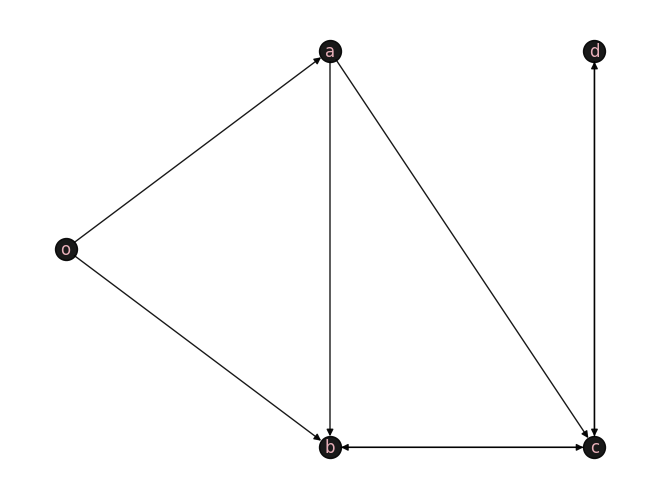

In [49]:
G1_parth = nx.DiGraph()
edges_list_1_h = [('o','a'),('o','b'),('a','b'),('a','c'),('b','c'),('d','c'), ('c', 'd'), ('c', 'b')]
G1_parth.add_edges_from(edges_list_1_h)
pos = {"o":[2,2], "a":[4,4], "b":[4,0], "c":[6,0], "d":[6,4] }
nx.draw(G1_parth,pos, **options)
plt.savefig("graphh.png")

In [50]:
print(f'Graph properties: strongly connected: {nx.algorithms.components.is_strongly_connected(G1_parth)} and  aperiodic: {nx.is_aperiodic(G1_parth)}.')

Graph properties: strongly connected: False and  aperiodic: True.


#### Specifically, node d cannot reach node o, and node o cannot reach node d. In other words, there is no directed path between these two nodes, preventing strong connectivity.

Your connected components are: 
[{'c', 'd', 'b'}, {'a'}, {'o'}]


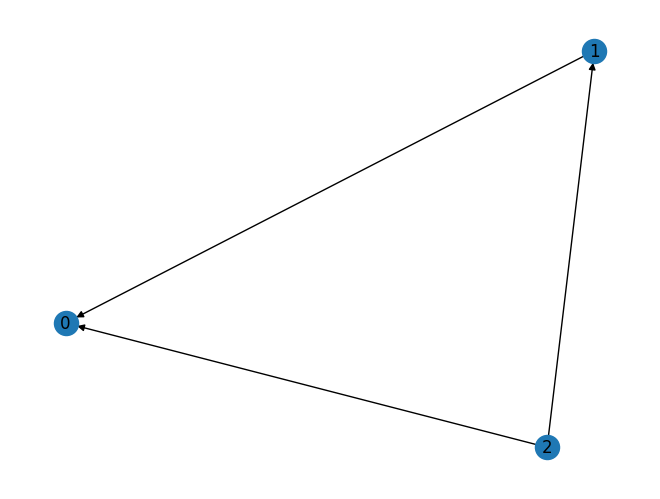

In [51]:
con_comp_h_list = list(nx.strongly_connected_components(G1_parth))
print("Your connected components are: ")
print(con_comp_h_list)
con_comp_h = nx.algorithms.components.condensation(G1_parth)
nx.draw(con_comp_h, with_labels=True)

In [52]:
# Count nodes with out-degree = 0 (sinks), so counting the nr of sinks
num_sinks_h = sum(1 for node in G1_parth if G1_parth.out_degree(node) == 0)
print("Number of sinks:", num_sinks_h)

Number of sinks: 0


In [53]:
print('The original transition matrix was: ')
tr_matrix

The original transition matrix was: 


array([[0.        , 0.4       , 0.2       , 0.        , 0.        ],
       [0.        , 0.        , 0.75      , 0.25      , 0.        ],
       [0.5       , 0.        , 0.        , 0.33333333, 0.        ],
       [0.        , 0.        , 0.33333333, 0.        , 0.66666667],
       [0.        , 0.5       , 0.        , 0.33333333, 0.        ]])

In [54]:
## adapting the transition matrix to the changes in the graph:
tr_matrix_h = np.array([[0, 2/5, 1/5, 0, 0],
                   [0, 0, 3/4, 1/4, 0],
                   [0, 0, 0, 1/3, 0],
                   [0, 0, 1/3, 0, 2/3],
                   [0, 0, 0, 1/3, 0]])
print('The new transition matrix is: ')
tr_matrix_h

The new transition matrix is: 


array([[0.        , 0.4       , 0.2       , 0.        , 0.        ],
       [0.        , 0.        , 0.75      , 0.25      , 0.        ],
       [0.        , 0.        , 0.        , 0.33333333, 0.        ],
       [0.        , 0.        , 0.33333333, 0.        , 0.66666667],
       [0.        , 0.        , 0.        , 0.33333333, 0.        ]])

In [55]:
degrees_h = np.sum(tr_matrix_h,axis=1)
D_h = np.diag(degrees_h)
P_h = np.linalg.inv(D_h) @ tr_matrix_h
print(P_h)

[[0.         0.66666667 0.33333333 0.         0.        ]
 [0.         0.         0.75       0.25       0.        ]
 [0.         0.         0.         1.         0.        ]
 [0.         0.         0.33333333 0.         0.66666667]
 [0.         0.         0.         1.         0.        ]]


In [56]:
x0_test1

[10, 20, 15, 25, 40]

In [57]:
opinions_h = []
sim_french_de_groot(30,P_h,x0_test1, opinions_h)

Opinions vector: is [18.33333333 17.5        25.         31.66666667 25.        ]
Opinions vector: is [20.         26.66666667 31.66666667 25.         31.66666667]
Opinions vector: is [28.33333333 30.         25.         31.66666667 25.        ]
Opinions vector: is [28.33333333 26.66666667 31.66666667 25.         31.66666667]
Opinions vector: is [28.33333333 30.         25.         31.66666667 25.        ]
Opinions vector: is [28.33333333 26.66666667 31.66666667 25.         31.66666667]
Opinions vector: is [28.33333333 30.         25.         31.66666667 25.        ]
Opinions vector: is [28.33333333 26.66666667 31.66666667 25.         31.66666667]
Opinions vector: is [28.33333333 30.         25.         31.66666667 25.        ]
Opinions vector: is [28.33333333 26.66666667 31.66666667 25.         31.66666667]
Opinions vector: is [28.33333333 30.         25.         31.66666667 25.        ]
Opinions vector: is [28.33333333 26.66666667 31.66666667 25.         31.66666667]
Opinions vector:

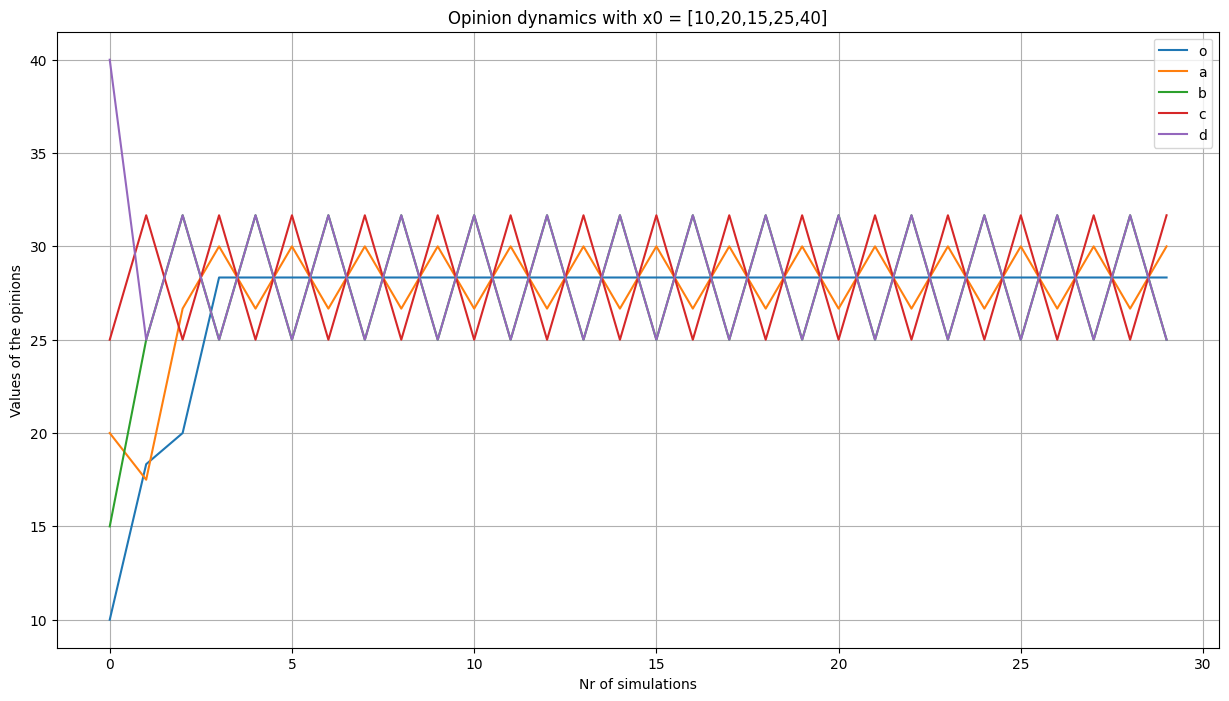

In [58]:
# Plot the opinions evolution in time
opinions_h = np.array(opinions_h)
plt.figure(figsize=[15,8])

for x in range(opinions_h.shape[1]):
    plt.plot(opinions_h[:,x])

plt.grid()
plt.legend(nodes_names)
plt.title("Opinion dynamics with x0 = [10,20,15,25,40]")
plt.xlabel("Nr of simulations")
plt.ylabel("Values of the opinions")
plt.savefig('oph.png', dpi=600)
plt.show()

## <center> Exercise 2 </center>

#### In this part we will again consider the network of Fig. 1, with weights (1). However, now we will simulate many particles moving around in the network in continuous time. Each of the particles in the network will move around just as the single particle moved around in Problem 1: the time it will stay in a node is exponentially distributed, and on average it will stay 1/ωi time-units in a node i before moving to one of its outneighbors. The next node it will visit is based on the probability matrix P = diag(ω) −1Λ, where ω = Λ1. Your task is to simulate this system from two different perspectives: the particle perspective, i.e. “follow the particle”, and the node perspective, i.e. “observe from the node”. Simulating the system from a particle perspective is exactly as in Problem 1, but here you have to follow many particles instead. To simulate the system from the node perspective you instead have to observe the particles from the node. When doing this you do not have to care about each single particle, but only about the number of particles in the node. Note that at node i, each particle in that node will stay there on average 1/ωi time units. Therefore, the node will pass along particles at a rate proportional to the number of particles in the node. In fact, if at time t the number of particles in node i is ni(t), it will pass along particles at a rate of ni(t)ωi.The departure times of the node can thus be seen as a Poisson process with rate ni(t)ωi. At each tick of the Poisson clock of the node, it will move a particle to a neighboring node. The node to which the particle will move is again based on the normalized transition rate matrix P.


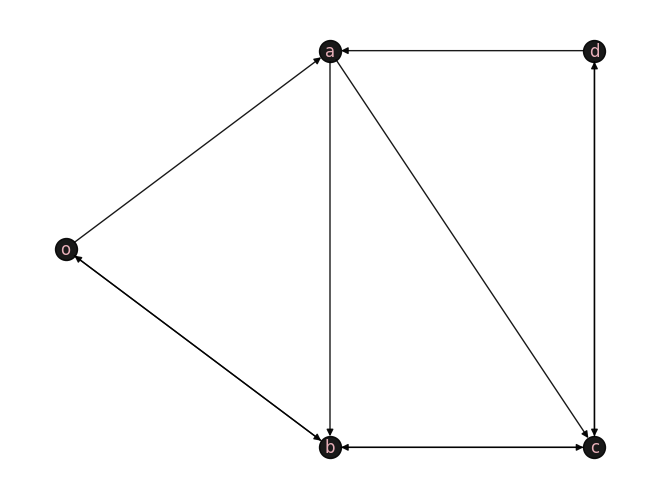

In [59]:
G_1 = nx.DiGraph()
edges_list_1 = [('o','a'),('o','b'),('a','b'),('a','c'),('b','o'),('b','c'),('d','a'),('d','c'), ('c', 'd'), ('c', 'b')]
G_1.add_edges_from(edges_list_1)
pos = {"o":[2,2], "a":[4,4], "b":[4,0], "c":[6,0], "d":[6,4] }
nx.draw(G_1,pos, **options)

#### a) Particle perspective:

*   If N = 100 particles all start in node a, what is the average time for a particle to return
to node a?
*   How does this compare to the answer in Problem 1, why?



In [60]:
tr_matrix_ex2 = np.array([[0, 2/5, 1/5, 0, 0], # Same matrix as in Exercise 1, but we rewrite it for purpose of clarity
                   [0, 0, 3/4, 1/4, 0],
                   [1/2, 0, 0, 1/3, 0],
                   [0, 0, 1/3, 0, 2/3],
                   [0, 1/2, 0, 1/3, 0]])


In [61]:
w = np.sum(tr_matrix_ex2, axis=1) # Sums of the columns of the matrix
w_star = np.max(w) # Maximum value of these sums
#compute the matrix of all the probability
P = tr_matrix_ex2/w_star
P = P + np.diag(np.ones(len(w))-np.sum(P,axis=1))
P

array([[0.4       , 0.4       , 0.2       , 0.        , 0.        ],
       [0.        , 0.        , 0.75      , 0.25      , 0.        ],
       [0.5       , 0.        , 0.16666667, 0.33333333, 0.        ],
       [0.        , 0.        , 0.33333333, 0.        , 0.66666667],
       [0.        , 0.5       , 0.        , 0.33333333, 0.16666667]])

In [62]:
def simulation_exercise2(initial_state, destination, P):
    pos = []  # 'pos' will keep track of the visited states for each particle
    transition_times = []  # 'transition_times' will store the time instances at which jumps or transitions happen

    for i in range(100):  # Create a vector for 100 particles, all starting from state 1 (node 'a') as requested
        pos.append([1])  # Each particle starts at node 'a' (state 1) as requested
        transition_times.append([0])  # The initial transition time for each particle is set to 0

    n_states = 5  # Number of states; these are mapped as follows: o = 0, a = 1, b = 2, c = 3, d = 4.
    checking_return = []  # A list to keep track of which particles have returned to node 'a'
    tot = 0  # Variable to count the total transition times of all particles.

    while len(checking_return) != 100:  # Continue the simulation until all 100 particles have returned to node 'a'.
        for i in range(len(pos)):  # Iterate over each particle in the simulation
            if len(pos[i]) == 1 or pos[i][-1] != 1:  # If the particle is not back at 'a', continue moving
                # np.random.choice selects the next state for the particle based on the transition probabilities (P)
                next_pos = np.random.choice(n_states, p=P[pos[i][-1], :])
                # Update the time of the next transition using a Poisson distribution
                t_next = -np.log(np.random.rand()) / w_star  # Update the global Poisson clock
                pos[i].append(next_pos)  # Add the new state (next position) to the particle's path
                next_transition_time = transition_times[i][-1] + t_next  # Add the time of the next transition
                transition_times[i].append(next_transition_time)  # Append the new transition time to the list

        # Update the checking_return list: True for particles that have reached node 'a'.
        checking_return = [True for x in pos if x[-1] == 1]

    for i in transition_times:  # Loop over the transition times of all particles.
        tot += i[-1]  # Add the last transition time of each particle to the total.

    return transition_times, pos, checking_return, tot / 100  # Return the transition times, positions, return status, and average time per particle.

In [63]:
transition_times, position, checking_return, res = simulation_exercise2(1,1,P)


In [64]:
print("The first 4 transition times are:")
print(transition_times[:4])
print(len(transition_times))
print(position[:4])
print(checking_return[:4])
print(res)

The first 4 transition times are:
[[0, 0.9072967236874987, 1.1708389780030812, 1.3421973978562411, 3.694086408009375, 4.514696814217554, 5.654936306858035, 6.513503678518693], [0, 0.21296282321394716, 0.9823942563607801, 1.5202358279818804], [0, 1.0489376284707268, 2.8672066896085076, 4.969723279292845], [0, 0.39882083889433895, 1.5491002228590305, 2.6178833136717214, 3.8862427965393365]]
100
[[1, 2, 0, 0, 2, 0, 0, 1], [1, 3, 4, 1], [1, 2, 0, 1], [1, 2, 3, 4, 1]]
[True, True, True, True]
5.723580188367297


In [65]:
list_tot =[]
def make_simulations_ex2(nr_sim, node_in, node_out, matrix):
    for i in range(nr_sim):
          t ,p ,c ,res = simulation_exercise2(node_in,node_out,matrix)
          list_tot.append(res)
    avg_particle_time = np.mean(list_tot)
    return avg_particle_time

In [66]:
make_simulations_ex2(100,1,1,P)


6.076408352500748

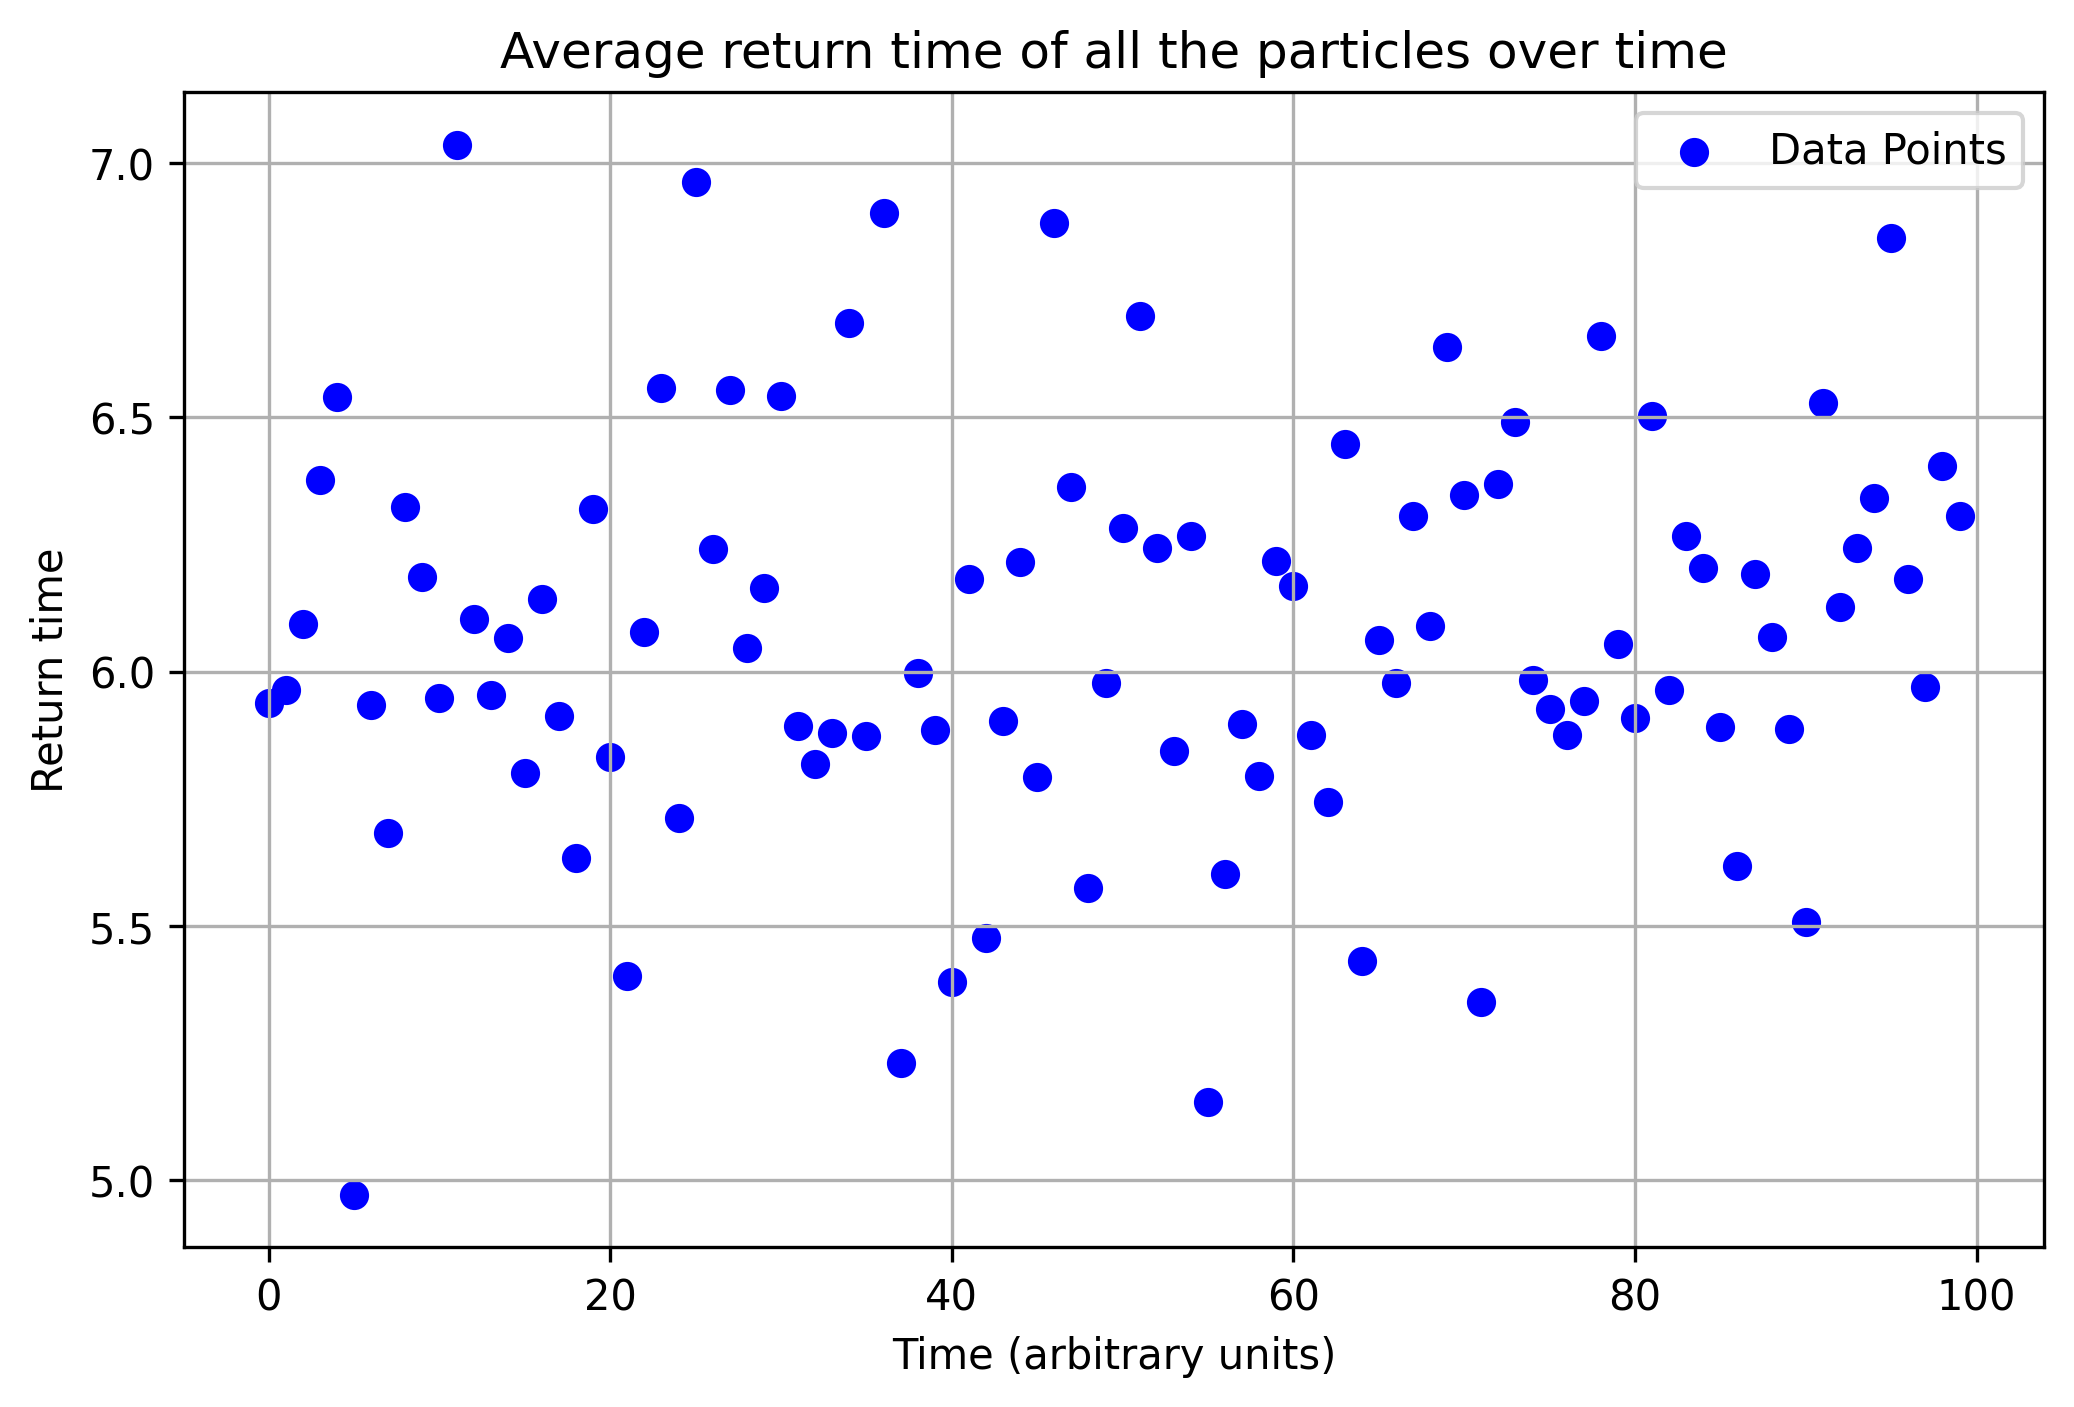

In [67]:

y_values = list_tot  # y-axis values are the averages of the list
x_values = [i for i in range(len(list_tot))]  # Generate x values as time steps

# Create the scatter plot
plt.figure(figsize=(8, 5), dpi = 300)
plt.scatter(x_values, y_values, color='blue', marker='o', label='Data Points')

# Add labels and title
plt.xlabel('Time (arbitrary units)')
plt.ylabel('Return time')
plt.title('Average return time of all the particles over time')
plt.legend()

plt.grid(True)
plt.savefig("scatterplot_ex2_particleperspective.png")
# Display the plot
plt.show()


In [68]:
list_tot_2 =[]
def make_simulations_ex2_2(nr_sim, node_in, node_out, matrix):
    for i in range(nr_sim):
          t ,p ,c ,res = simulation_exercise2(node_in,node_out,matrix)
          list_tot_2.append(res)
    avg_particle_time = np.mean(list_tot_2)
    return avg_particle_time

In [69]:
make_simulations_ex2_2(1000,1,1,P)

6.059406577685398

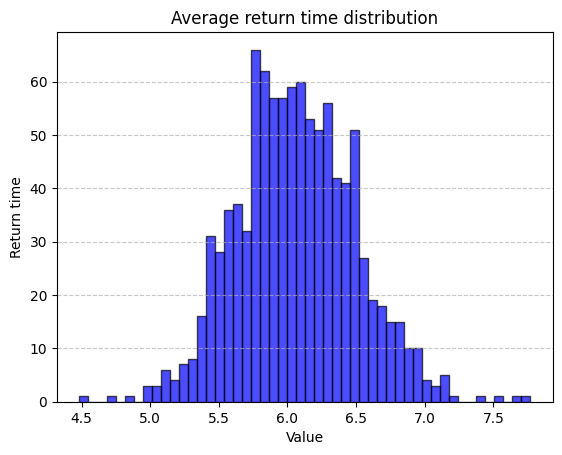

In [70]:
values = list_tot_2  # Values to plot the frequency for

# Create the histogram (frequency plot)
plt.hist(values, bins=50, color='blue', edgecolor='black', alpha=0.7)

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Return time')
plt.title('Average return time distribution')

plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.show()

#### b) Node perspective:


*   If N = 100 particles start in node a, and the system is simulated for 60 time units, what
is the average number of particles in the different nodes at the end of the simulation?
*   Illustrate the simulation above with a plot showing the number of particles in each node
during the simulation time.
*   Compare the simulation result in the first point above with the stationary distribution of
the continuous-time random walk followed by the single particles.




In [71]:
# Compute the simulation
def simulation_node_perspective(Q, w, pos, time_units):
    """
    Simulates the movement of particles between nodes in a network.

    Args:
        Q: Transition probability matrix.
        w: Rate parameter for exponential distribution.
        pos: Initial particle positions as a matrix (nodes x particles).
        time_units: Total time for which the simulation will run.

    Returns:
        pos: Matrix of particle positions at each time step.
        transition_times: Array of times at which transitions occur.
    """

    # Generate the time for the first transition using an exponential distribution
    t_next = -np.log(np.random.rand()) / w
    i = 1  # Initialize the step counter

    # Initialize transition times with a starting point of 0
    transition_times = np.array([0])
    # Compute the cumulative sum of transition probabilities for each node
    Q_cum = np.cumsum(Q, axis=1)

    # Simulation loop
    while transition_times[i - 1] < time_units:
        # Generate a random number between 0 and 100 to select a node
        elem = int(np.random.rand() * 100)

        # Compute cumulative intervals based on the number of particles in each node
        intervals = np.cumsum(pos[:, i - 1])

        # Identify the node from which a particle will leave
        node_from = np.argwhere(intervals > elem)[0]

        # Determine the next node to which the particle will move
        next_pos = np.argwhere(Q_cum[int(node_from)] > np.random.rand())[0]

        # Update the particle counts for the nodes
        new_pos = pos[:, i - 1]  # Copy the current particle positions
        new_pos[node_from] -= 1  # Remove one particle from the source node
        new_pos[next_pos] += 1   # Add one particle to the destination node

        # Expand dimensions for compatibility and append the updated positions
        new_pos = np.expand_dims(new_pos, axis=1)
        pos = np.append(pos, new_pos, axis=1)

        # Append the cumulative transition time
        transition_times = np.append(transition_times, transition_times[i - 1] + t_next)

        # Generate the time for the next transition
        t_next = -np.log(np.random.rand()) / w

        # Increment the step counter
        i += 1

    # Return the final particle positions and the transition times
    return pos, transition_times


In [72]:
# Problem initialization
n_particles = 100
time_units = 60
n_simulations = 100
particles_config = np.zeros((n_simulations,5))
rate = 100
Q = Qmatrix_Jump_Chain(tr_matrix = tr_matrix)

for j in range(n_simulations):
    # Initialize position and times
    init_pos = np.zeros([5,1], dtype=int)
    init_pos[1] = n_particles # <= All particles start from node a
    # States are mapped in this way: {o = 0, a = 1, b = 2, c = 3, d = 4}
    particles, transition_times = simulation_node_perspective(Q, w = rate, pos=init_pos, time_units = time_units)
    last_pos = particles[:,-1]
    particles_config[j] = last_pos
# Compute the simulated mean of particles per node
print("The simulated mean of particles per node is : {}".format(np.mean(particles_config,axis=0)))

<ipython-input-71-c1e57e986bd2>:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  next_pos = np.argwhere(Q_cum[int(node_from)] > np.random.rand())[0]


The simulated mean of particles per node is : [23.25 15.93 27.42 18.35 15.05]


In [73]:
simulation_mean = np.mean(particles_config,axis=0)
simulation_mean

array([23.25, 15.93, 27.42, 18.35, 15.05])

<ipython-input-71-c1e57e986bd2>:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  next_pos = np.argwhere(Q_cum[int(node_from)] > np.random.rand())[0]


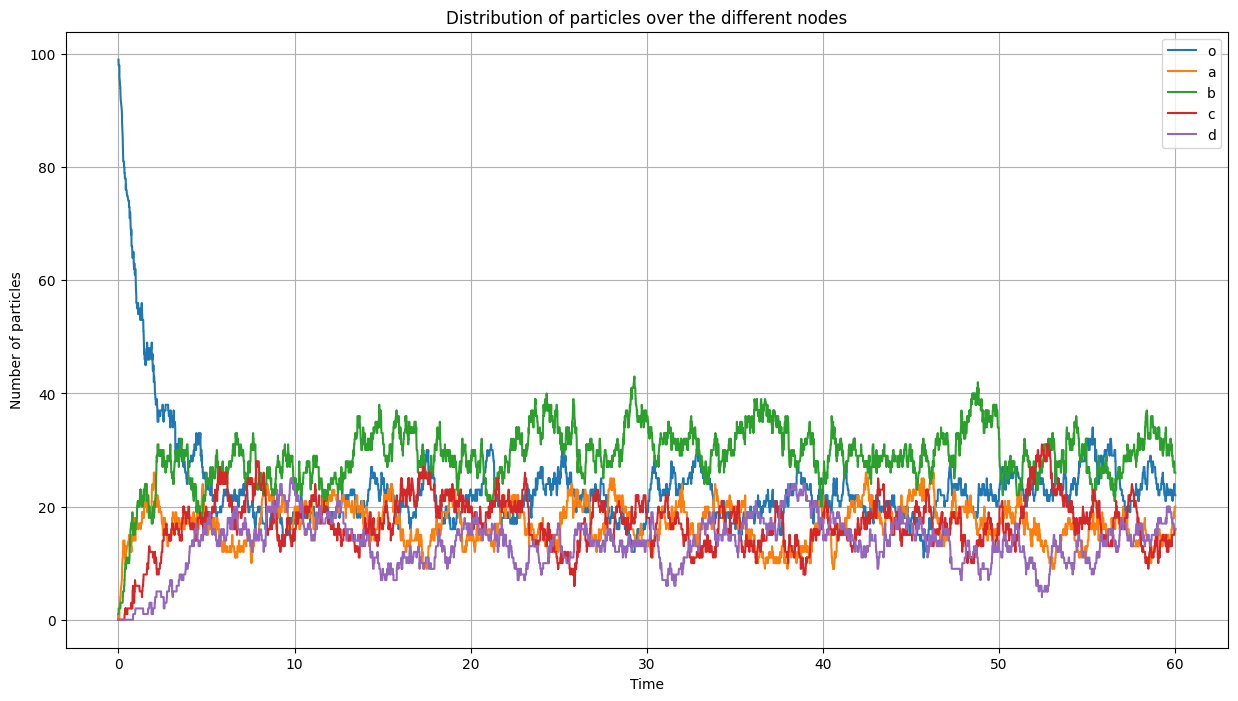

In [79]:
# Initialize position and times
init_pos = np.zeros([5,1], dtype=int)
init_pos[0] = n_particles # <= All particles start from node o
# States are mapped in this way: {o = 0, a = 1, b = 2, c = 3, d = 4}
particles_config, transition_times = simulation_node_perspective(Q, w = rate, pos=init_pos, time_units = time_units)

plt.figure(figsize=[15,8])
for x in range(particles_config.shape[0]):
    plt.plot(transition_times, particles_config[x,:])

plt.grid()
plt.legend(nodes_names)
plt.title("Distribution of particles over the different nodes")
plt.xlabel("Time")
plt.ylabel("Number of particles")
plt.show()

In [76]:
eigenvector_ex2b = comp_eigenvector_one(Q) # Using the above defined function to get the stationary distribution of the continuous-time random walk followed by the single particle

Eigenvector corresponding to eigenvalue ~1: [0.23058252 0.16504854 0.27669903 0.18203883 0.14563107]


In [74]:
normalized_vector = simulation_mean / np.sum(simulation_mean)
normalized_vector

array([0.2325, 0.1593, 0.2742, 0.1835, 0.1505])

In [78]:
quadratic_error = (normalized_vector - eigenvector_ex2b) ** 2
quadratic_error

array([3.67671317e-06, 3.30457545e-05, 6.24514657e-06, 2.13500330e-06,
       2.37064992e-05])

## <center> Exercise 3 </center>

#### In this part we consider the open network of Figure 2, with transition rate matrix Λopen according to (2). For this system, particles will enter the system at node o according to a Poisson process with input rate λ. Each node will then pass along a particle according to a given rate, similar to what you did in Problem 2 with the “node perspective”. Let ω = Λ1 and let N(t) denote the vector of number of particles in each node at time t. You will simulate two different scenarios that differ by what rate the nodes will pass along particles: i) proportional rate, and ii) fixed rate. In scenario i), each node i will pass along particles according to a Poisson process with rate equal to the number of particles in the node times the rate of the local Poisson clock of node i, i.e., the node i will pass along particles rate with rate ωiNi(t). In scenario ii), each node i will instead pass along particles with a fixed rate ωi. Since node d does not have a node to send its particles to, we assume that ωd = 2. When the Poisson clock of node d ticks, you could simply decrease the number of particles in the node by one (if there are any particles in the node). Equivalently think of another node d' connected to node d, such that at every tick of the Poisson clock of d, it sends a particle to node d'.



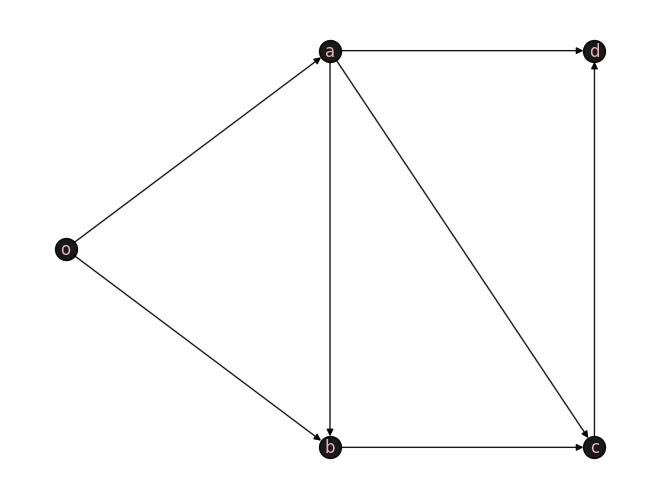

In [80]:
G_open = nx.DiGraph()
edges_list_2 = [("o","a"),("o","b"),("a","b"),("a","c"),("a","d"),("b","c"),("c","d")]
G_open.add_edges_from(edges_list_2)
pos = {"o":[2,2], "a":[4,3], "b":[4,1], "c":[6,1], "d":[6,3] }
nx.draw(G_open, pos, **options)

In [81]:
tr_matrix_2 = np.array([[  0, 3/4, 3/4 ,  0,   0],
                     [  0,   0, 1/4, 1/4, 2/4],
                     [  0,   0,   0,   1,   0],
                     [  0,   0,   0,   0,   1],
                     [  0,   0,   0,   0,   1]]) # Here we add a self-loop in order to make the matrix invertible

w = np.sum(tr_matrix_2, axis=1)
w_star = np.max(w)
Q = Qmatrix_Jump_Chain(tr_matrix_2)
D = np.diag(w)
P = np.linalg.inv(D) @ tr_matrix_2
P_cum = np.cumsum(P, axis=1)

#### a) Proportional rate:

*   Simulate the system for 60 time units and plot the evolution of the number of particles
in each node over time with input rate λ = 100.
*   What is the largest input rate that the system can handle without blowing up?



In [82]:
# Parameters setting
origin = 0
destination = 4
time_units = 60
input_rate = 100

pos = np.zeros([5,1], dtype=int) # Positions storing array
transition_times = np.array([0]) # Transitions times storing array

input_next  = -np.log(np.random.rand()) / input_rate # Setting up input Poisson clock

nodes_next = []
for x in range(pos.shape[0]):
    if pos[x,0] != 0 :
        nodes_next.append(  -np.log(np.random.rand()) / (pos[x,0] * w[x] )) # Setting up nodes Poisson clock
    else: nodes_next.append( float("inf") )
i = 1


while transition_times[i-1] < time_units: # Simulation goes on until all the desired time units


    if  input_next < min(nodes_next): # Situation in which the input clock ticks before a new particle goes into the network
        new_pos = pos[:,i-1] # Update positions
        new_pos[0] += 1
        new_pos = np.expand_dims(new_pos, axis=1)

        pos = np.append(pos, new_pos, axis=1)
        transition_times = np.append(transition_times, transition_times[i-1] + input_next) # Update transition times


    else:  # Situation in which a node clock ticks before a particle in that node make some moves
        node_from = np.argmin(nodes_next)


        if pos[node_from,i-1] >0 : # Checking for the presence of particles in that specific node


            if int(node_from) == destination : # If particles start from node d, we simply remove them
                new_pos = pos[:,i-1] # Update positions
                new_pos[destination] -= 1
                new_pos = np.expand_dims(new_pos, axis=1)
                pos = np.append(pos, new_pos, axis=1)


            else : # If particles start from a node different then d
                next_pos = np.argwhere(P_cum[int(node_from)] > np.random.rand())[0] # Update positions
                new_pos = pos[:,i-1]
                new_pos[node_from] =  new_pos[node_from] - 1
                new_pos[next_pos] += 1
                new_pos = np.expand_dims(new_pos, axis=1)
                pos = np.append(pos, new_pos, axis=1)


        else : # Absence of particles
            new_pos = pos[:,i-1] # Update positions
            new_pos = np.expand_dims(new_pos, axis=1)
            pos = np.append(pos, new_pos, axis=1)

        transition_times = np.append(transition_times, transition_times[i-1] + nodes_next[node_from]) # Update transition times


    nodes_next = [] # Update nodes' clock
    for x in range(pos.shape[0]):
        if pos[x,i] != 0 :
            nodes_next.append(  -np.log(np.random.rand()) / (pos[x,i] * w[x]) )
        else: nodes_next.append( float("inf") )


    input_next = -np.log(np.random.rand())/ input_rate # Update input clock
    i += 1

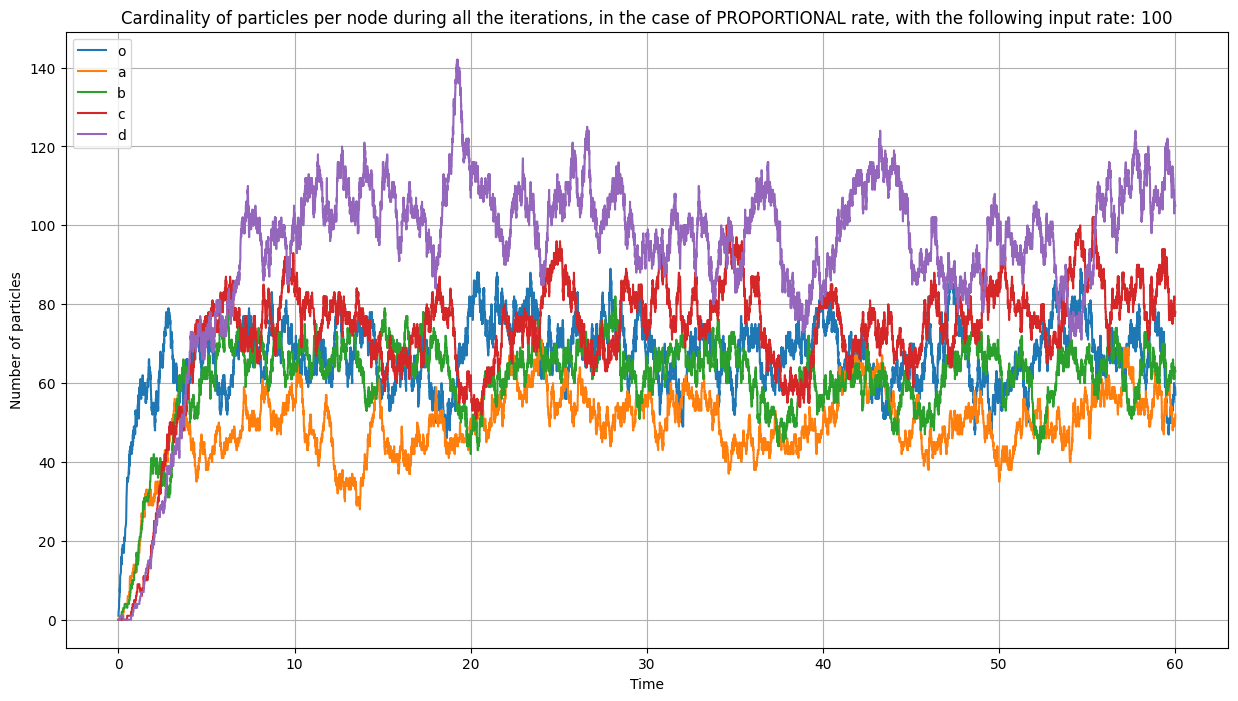

In [83]:
# Plotting the results

plt.figure(figsize=[15,8])

for x in range(pos.shape[0]):
    plt.plot(transition_times, pos[x,:])

plt.grid()
nodes_names = ["o","a","b","c","d"]
plt.legend(nodes_names)
plt.title("Cardinality of particles per node during all the iterations, in the case of PROPORTIONAL rate, with the following input rate: {}".format(input_rate))
plt.xlabel("Time")
plt.ylabel("Number of particles")
plt.show()

#### In order to evaluate what is the largest input rate that the system can handle without blowing up, we simulate with an higher(w.r.t. 100) input rate of 1000.

In [84]:
# Parameters setting
origin = 0
destination = 4
time_units = 60
input_rate = 1000

pos = np.zeros([5,1], dtype=int) # Positions storing array
transition_times = np.array([0]) # Transitions times storing array

input_next  = -np.log(np.random.rand()) / input_rate # Setting up input Poisson clock

nodes_next = []
for x in range(pos.shape[0]):
    if pos[x,0] != 0 :
        nodes_next.append(  -np.log(np.random.rand()) / (pos[x,0] * w[x] )) # Setting up nodes Poisson clock
    else: nodes_next.append( float("inf") )
i = 1


while transition_times[i-1] < time_units: # Simulation goes on until all the desired time units


    if  input_next < min(nodes_next): # Situation in which the input clock ticks before a new particle goes into the network
        new_pos = pos[:,i-1] # Update positions
        new_pos[0] += 1
        new_pos = np.expand_dims(new_pos, axis=1)

        pos = np.append(pos, new_pos, axis=1)
        transition_times = np.append(transition_times, transition_times[i-1] + input_next) # Update transition times


    else:  # Situation in which a node clock ticks before a particle in that node make some moves
        node_from = np.argmin(nodes_next)


        if pos[node_from,i-1] >0 : # Checking for the presence of particles in that specific node


            if int(node_from) == destination : # If particles start from node d, we simply remove them
                new_pos = pos[:,i-1] # Update positions
                new_pos[destination] -= 1
                new_pos = np.expand_dims(new_pos, axis=1)
                pos = np.append(pos, new_pos, axis=1)


            else : # If particles start from a node different then d
                next_pos = np.argwhere(P_cum[int(node_from)] > np.random.rand())[0] # Update positions
                new_pos = pos[:,i-1]
                new_pos[node_from] =  new_pos[node_from] - 1
                new_pos[next_pos] += 1
                new_pos = np.expand_dims(new_pos, axis=1)
                pos = np.append(pos, new_pos, axis=1)


        else : # Absence of particles
            new_pos = pos[:,i-1] # Update positions
            new_pos = np.expand_dims(new_pos, axis=1)
            pos = np.append(pos, new_pos, axis=1)

        transition_times = np.append(transition_times, transition_times[i-1] + nodes_next[node_from]) # Update transition times


    nodes_next = [] # Update nodes' clock
    for x in range(pos.shape[0]):
        if pos[x,i] != 0 :
            nodes_next.append(  -np.log(np.random.rand()) / (pos[x,i] * w[x]) )
        else: nodes_next.append( float("inf") )


    input_next = -np.log(np.random.rand())/ input_rate # Update input clock
    i += 1

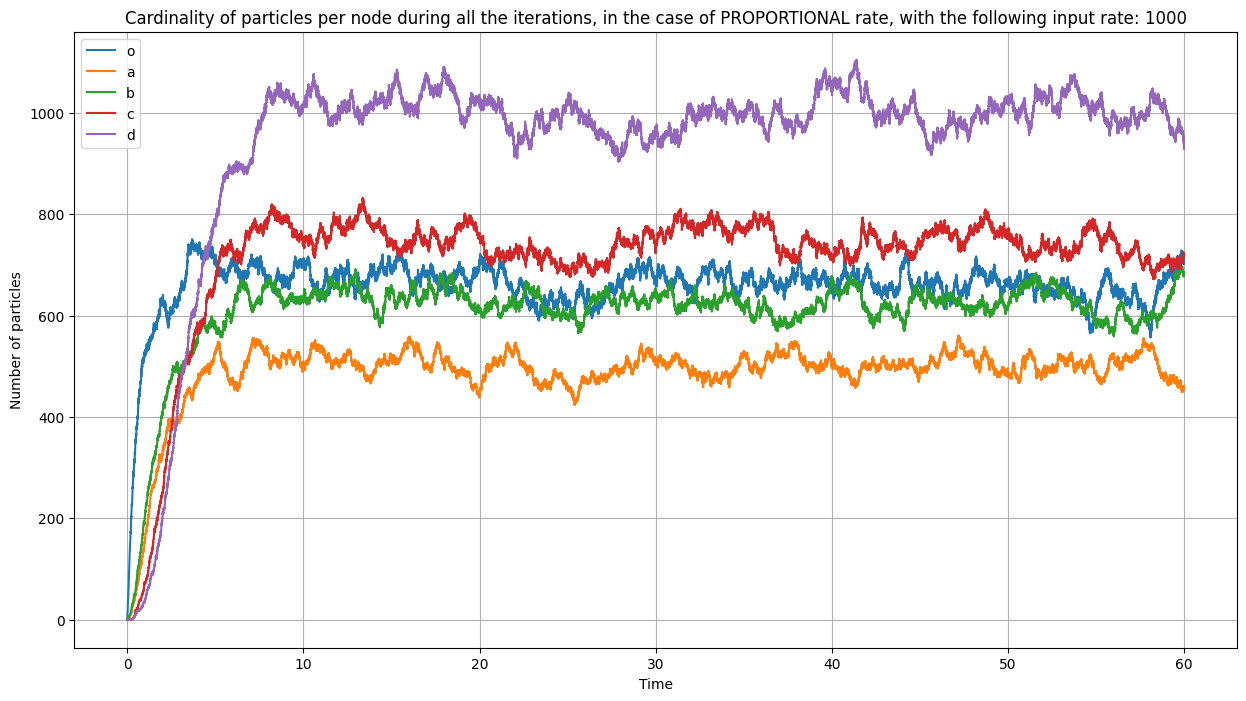

In [85]:
# Plotting the results

plt.figure(figsize=[15,8])

for x in range(pos.shape[0]):
    plt.plot(transition_times, pos[x,:])

plt.grid()
nodes_names = ["o","a","b","c","d"]
plt.legend(nodes_names)
plt.title("Cardinality of particles per node during all the iterations, in the case of PROPORTIONAL rate, with the following input rate: {}".format(input_rate))
plt.xlabel("Time")
plt.ylabel("Number of particles")
plt.show()

#### We can see from the plot that the system, in the case of proportional rate, can handle a potentially infinite input rate without blowing up.

#### b) Fixed rate:

*   Simulate the system for 60 time units and plot the evolution of number of particles in
each node over time with input rate λ = 1.
*   What is the largest input rate that the system can handle without blowing up? Motivate
your answer.



In [87]:
# Parameters setting
origin = 0
destination = 4
time_units = 60
input_rate = 1

pos = np.zeros([5,1], dtype=int) # Positions storing array
transition_times = np.array([0]) # Transitions times storing array

input_next  = -np.log(np.random.rand()) / input_rate # Setting up input Poisson clock

nodes_next = []
for x in range(pos.shape[0]):
       nodes_next.append( -np.log(np.random.rand()) / 1 ) # Setting up nodes Poisson clock in a fixed manner
i = 1


while transition_times[i-1] < time_units: # Simulation goes on until all the desired time units


    if  input_next < min(nodes_next) or np.sum(pos[:,i-1]) == 0: # Situation in which the input clock ticks before a new particle goes into the network
        new_pos = pos[:,i-1] # Update positions
        new_pos[0] += 1
        new_pos = np.expand_dims(new_pos, axis=1)

        pos = np.append(pos, new_pos, axis=1)
        transition_times = np.append(transition_times, transition_times[i-1] + input_next) # Update transition times


    else:  # Situation in which a node clock ticks before a particle in that node make some moves
        node_from = np.argmin(nodes_next)


        if pos[node_from,i-1] >0 : # Checking for the presence of particles in that specific node


            if int(node_from) == destination : # If particles start from node d, we simply remove them
                new_pos = pos[:,i-1] # Update positions
                new_pos[destination] -= 1
                new_pos = np.expand_dims(new_pos, axis=1)
                pos = np.append(pos, new_pos, axis=1)


            else : # If particles start from a node different then d
                next_pos = np.argwhere(P_cum[int(node_from)] > np.random.rand())[0] # Update positions
                new_pos = pos[:,i-1]
                new_pos[node_from] =  new_pos[node_from] - 1
                new_pos[next_pos] += 1
                new_pos = np.expand_dims(new_pos, axis=1)
                pos = np.append(pos, new_pos, axis=1)


        else : # Absence of particles
            new_pos = pos[:,i-1] # Update positions
            new_pos = np.expand_dims(new_pos, axis=1)
            pos = np.append(pos, new_pos, axis=1)

        transition_times = np.append(transition_times, transition_times[i-1] + nodes_next[node_from]) # Update transition times


    nodes_next = [] # Update nodes' clock
    for x in range(pos.shape[0]):
        nodes_next.append( -np.log(np.random.rand()) / 1 )


    input_next = -np.log(np.random.rand())/ input_rate # Update input clock
    i += 1

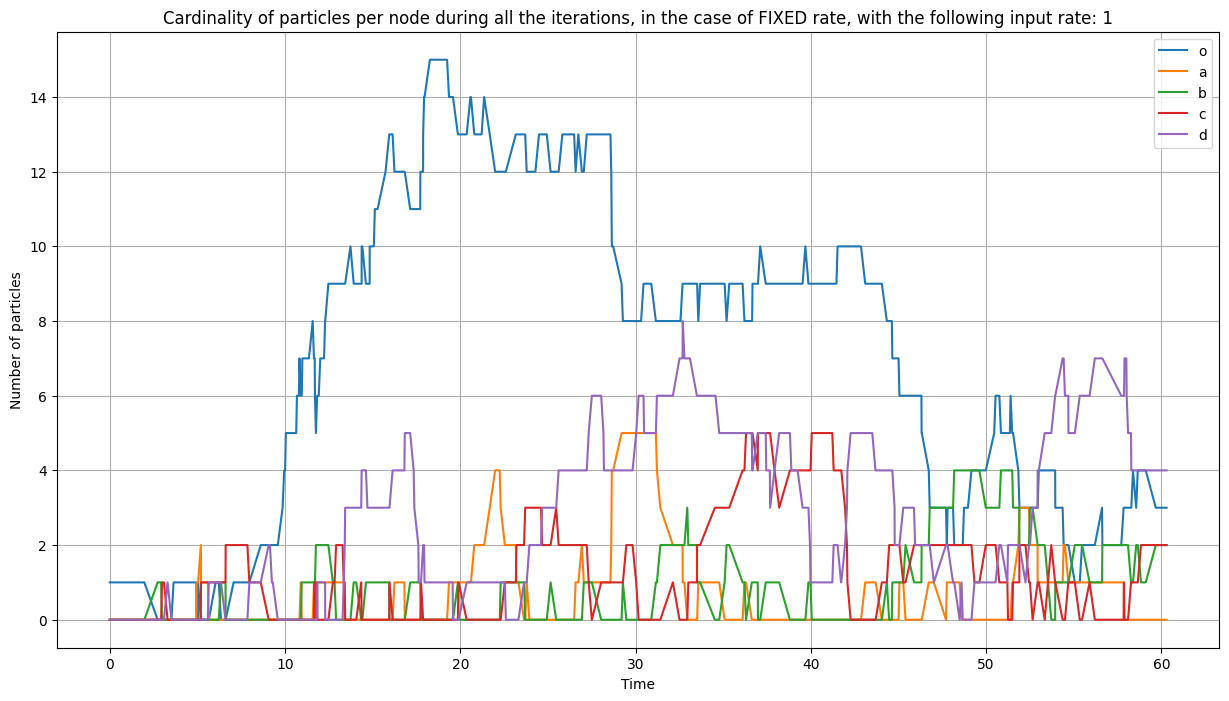

In [88]:
# Plotting the results

plt.figure(figsize=[15,8])

for x in range(pos.shape[0]):
    plt.plot(transition_times, pos[x,:])

plt.grid()
nodes_names = ["o","a","b","c","d"]
plt.legend(nodes_names)
plt.title("Cardinality of particles per node during all the iterations, in the case of FIXED rate, with the following input rate: {}".format(input_rate))
plt.xlabel("Time")
plt.ylabel("Number of particles")
plt.show()

#### In order to evaluate what is the largest input rate that the system can handle without blowing up, we simulate with an higher(w.r.t. 1) input rate of 2.

In [89]:
# Parameters setting
origin = 0
destination = 4
time_units = 60
input_rate = 2

pos = np.zeros([5,1], dtype=int) # Positions storing array
transition_times = np.array([0]) # Transitions times storing array

input_next  = -np.log(np.random.rand()) / input_rate # Setting up input Poisson clock

nodes_next = []
for x in range(pos.shape[0]):
       nodes_next.append( -np.log(np.random.rand()) / 1 ) # Setting up nodes Poisson clock in a fixed manner
i = 1


while transition_times[i-1] < time_units: # Simulation goes on until all the desired time units


    if  input_next < min(nodes_next) or np.sum(pos[:,i-1]) == 0: # Situation in which the input clock ticks before a new particle goes into the network
        new_pos = pos[:,i-1] # Update positions
        new_pos[0] += 1
        new_pos = np.expand_dims(new_pos, axis=1)

        pos = np.append(pos, new_pos, axis=1)
        transition_times = np.append(transition_times, transition_times[i-1] + input_next) # Update transition times


    else:  # Situation in which a node clock ticks before a particle in that node make some moves
        node_from = np.argmin(nodes_next)


        if pos[node_from,i-1] >0 : # Checking for the presence of particles in that specific node


            if int(node_from) == destination : # If particles start from node d, we simply remove them
                new_pos = pos[:,i-1] # Update positions
                new_pos[destination] -= 1
                new_pos = np.expand_dims(new_pos, axis=1)
                pos = np.append(pos, new_pos, axis=1)


            else : # If particles start from a node different then d
                next_pos = np.argwhere(P_cum[int(node_from)] > np.random.rand())[0] # Update positions
                new_pos = pos[:,i-1]
                new_pos[node_from] =  new_pos[node_from] - 1
                new_pos[next_pos] += 1
                new_pos = np.expand_dims(new_pos, axis=1)
                pos = np.append(pos, new_pos, axis=1)


        else : # Absence of particles
            new_pos = pos[:,i-1] # Update positions
            new_pos = np.expand_dims(new_pos, axis=1)
            pos = np.append(pos, new_pos, axis=1)

        transition_times = np.append(transition_times, transition_times[i-1] + nodes_next[node_from]) # Update transition times


    nodes_next = [] # Update nodes' clock
    for x in range(pos.shape[0]):
        nodes_next.append( -np.log(np.random.rand()) / 1 )


    input_next = -np.log(np.random.rand())/ input_rate # Update input clock
    i += 1

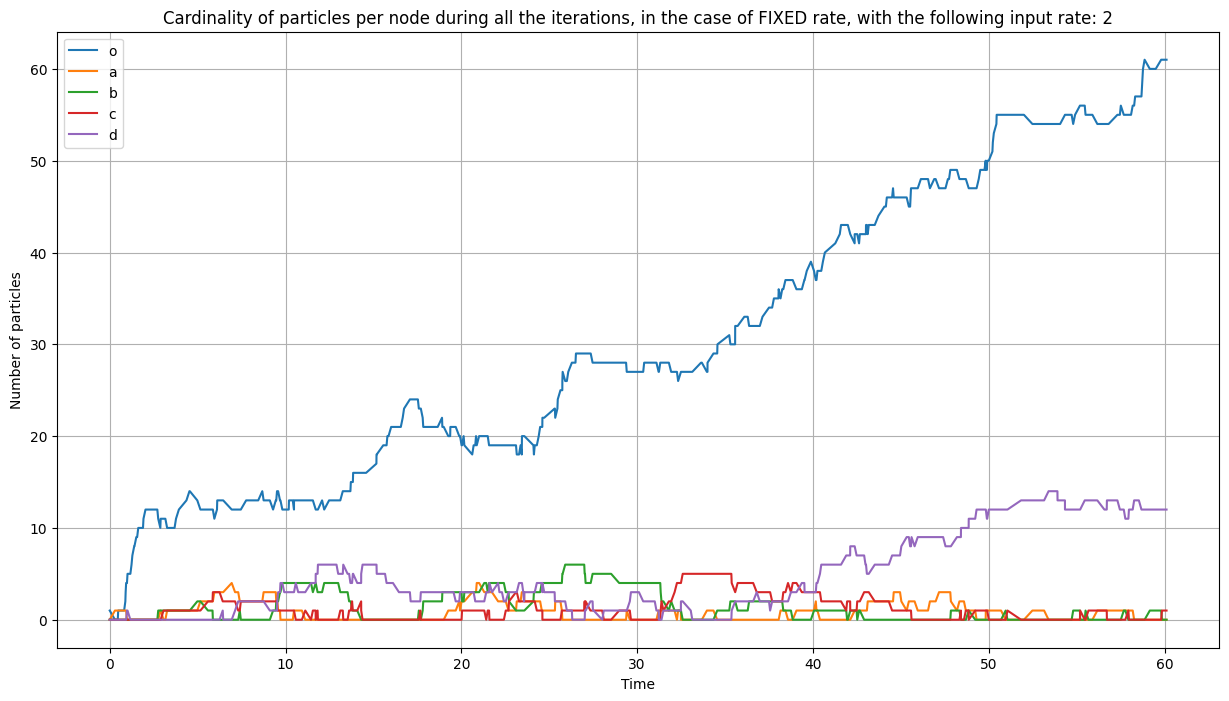

In [90]:
# Plotting the results

plt.figure(figsize=[15,8])

for x in range(pos.shape[0]):
    plt.plot(transition_times, pos[x,:])

plt.grid()
nodes_names = ["o","a","b","c","d"]
plt.legend(nodes_names)
plt.title("Cardinality of particles per node during all the iterations, in the case of FIXED rate, with the following input rate: {}".format(input_rate))
plt.xlabel("Time")
plt.ylabel("Number of particles")
plt.show()

#### We can see from the plot that the system, in the case of fixed rate, can handle only an input rate of 1, without blowing up.